In [1]:
%matplotlib widget

import sys
import os
import time
import math as math
from datetime import datetime
import pickle 
import numpy as np
import astropy as ast
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, Column
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from astropy.time import Time
from photutils.aperture import EllipticalAnnulus, aperture_photometry
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate
import scipy.constants
import scipy.special
import scipy.misc
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.interpolate
from scipy.interpolate import CubicSpline
import glob2
import shutil
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm as tqdm

import cv2

import Utility3_4 as ut

from readMDA_Mod2 import *
from ScanFunctions_plot_mod import *
import mda as mda

import pprint

b = 10**5

DimY = 1096
DimX = 1936

Offset = 2 #ADU Blacklevel Offset

Gain = 2.398
SigmaGain = 0.069

#SMALL_SIZE = 15
#MEDIUM_SIZE = 15
#BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


IEX_nData not imported


In [2]:
def kappa(num):
    pathString = 'C:\\Users\\Colin Packard\\PythonWorkspace\\ArgonneClean\\MDA_TEST\\Kappa_00'
    return pathString + str(int(num)) + '.mda'

def kappa_old(num):
    pathString = 'C:\\Users\\Colin Packard\\PythonWorkspace\\ArgonneClean\\OldMDA\\Kappa_00'
    return pathString + str(int(num)) + '.mda'

def get_d_index(fname,detNum,verbose = False):
    data_file  = mda.readMDA(fname, maxdim=4, verbose=0, showHelp=0)
    D={}
    n=len(data_file)-1
    for i in range(0,data_file[n].nd):
        detector=data_file[n].d[i].fieldName
        D[int(detector[1:])]=(data_file[n].d[i].name,i)
        
        if verbose == True:
            print_string = "detNum: " + str(int(detector[1:])) + ", Name: " +  data_file[n].d[i].name + ", d_index: " + str(i)
            print(print_string)
    #if verbose == True:
    #    pprint.pprint(D)
    
    d_index=D[detNum][1]
        
    if verbose == True:
        print("")
        print("Detector " + str(detNum) + " has d_index " + str(d_index))
    
    return d_index

def get_SRS_parameters(data,SRSnum):
    #Returns the gain settings for a given SRS number
    #SRS_1: Mesh
    #SRS_3: Diode D3
    #jessica uses offset_gain_value as offset_value
    
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    
    offset_value = data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL']
    offset_value = offset_value[2][0]
    offset_sign = data[0]['29idd:A'+str(SRSnum)+'offset_sign.VAL']
    offset_sign = offset_sign[2]

    offset_gain_value = data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'] #This is what jessica used for offset_value
    offset_gain_value = offset_gain_value[2]
    offset_gain_unit_string = data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL']
    offset_gain_unit_string = offset_gain_unit_string[2]

    gain = data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL']
    gain = gain[2]
    gain_unit_string = data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL']
    gain_unit_string = gain_unit_string[2]
    
    gain_units = unit_sciNote[gain_unit_string[:-2]]
    offset_gain_units = unit_sciNote[offset_gain_unit_string]
    
    gain = float(gain)
    gain_units = float(gain_units)
    offset_value = float(offset_value)
    offset_gain_value = float(offset_gain_value)
    offset_gain_units = float(offset_gain_units)
    
    return gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string

def get_beam_parameters(data):
    
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    
    slit_size = data[0]['29idb:Slit4Vt2.C'] #'slit3D size'
    slit_size = slit_size[2][0]
    slit_unit_string = 'um' #slit size is given in units of um
    
    polarization = data[0]['ID29:ActualMode']
    polarization = polarization[2] #string

    desired_photon_energy = data[0]['29idmono:ENERGY_SP'] 
    desired_photon_energy_units_string = desired_photon_energy[1] #string
    desired_photon_energy = desired_photon_energy[2][0]
    
    calculated_photon_energies = np.array(data[1].d[2].data)
    calculated_photon_energy = np.mean(calculated_photon_energies)
    std_calculated_photon_energy = np.std(calculated_photon_energies)
    calculated_photon_energy_units_string = data[1].d[2].unit #should be a string
    
    slit_size = float(slit_size)
    desired_photon_energy = float(desired_photon_energy)
    
    return slit_size, slit_unit_string, polarization, desired_photon_energy, desired_photon_energy_units_string, calculated_photon_energy, std_calculated_photon_energy, calculated_photon_energy_units_string
    

    
def calc_current(fname,detNum,subtract_baseline = True):
    """
    returns the current in Amps
    subtract_baseline = True to subtract dark signal
    """
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    #scaler_counts_pv = '29idMZ0:scaler1.TP'
    data = mda.readMDA(fname)
    d_index = get_d_index(fname,detNum,verbose = False)
    scaler_value = np.array(data[1].d[d_index].data)
    
    SRS_Dict = {31:1,32:2,33:3,34:4}
    SRSnum = SRS_Dict[detNum]
    
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
   
    current_Amp = scaler_value * gain * gain_units/b
    #baseline = offset_value * offset_gain_value * offset_gain_units
    baseline = offset_value * offset_gain_units #This is how Jessica did it.
    
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")
    

    if subtract_baseline:
        #print("Baseline: " + str(baseline/1e-12) + " [pA]")
        current_Amp = current_Amp + baseline #This is the way Jessica had it
        #current_Amp = current_Amp - baseline #The alternative
        
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")

    return current_Amp

def calc_current_given_gain(fname,detNum,gain,gain_unit_string,subtract_baseline = True):
    """
    returns the current in Amps
    subtract_baseline = True to subtract dark signal
    """
    data = mda.readMDA(fname)
    d_index = get_d_index(fname,detNum,verbose = False)
    scaler_value = np.array(data[1].d[d_index].data)
    
    SRS_Dict = {31:1,32:2,33:3,34:4}
    SRSnum = SRS_Dict[detNum]
    
    unit = {'pA/V':1e-12, 'nA/V':1e-9, 'uA/V':1e-6, 'mA/V':1e-3}
    gain_units = unit[gain_unit_string]
    
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
   
    current_Amp = scaler_value * gain * gain_units/b
    #baseline = offset_value * offset_gain_value * offset_gain_units
    #baseline = offset_value * offset_gain_units #This is how Jessica did it.

    #if subtract_baseline:
        #print("Baseline: " + str(baseline/1e-12) + " [pA]")
        #current_Amp = current_Amp + baseline #This is the way Jessica had it
        #current_Amp = current_Amp - baseline #The alternative
        
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")

    return current_Amp

def find_current_array_pA(scalar_value,gain,gain_unit_string):
    
    unit = {'pA/V':1e-12, 'nA/V':1e-9, 'uA/V':1e-6, 'mA/V':1e-3}
    gain_units = unit[gain_unit_string]
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
    current_Amp = scalar_value * gain * gain_units/b
    
    current_pA = current_Amp/unit['pA/V']
    
    mean_current_pA = np.mean(current_pA)
    mean_current_pA_string ="{:e}".format(mean_current_pA) + " [pA]"
    
    std_current_pA = np.std(current_pA)
    std_current_pA_string = "{:e}".format(std_current_pA) + " [pA]"
    
    return current_pA, mean_current_pA, std_current_pA, mean_current_pA_string, std_current_pA_string

def find_current_array_dark_subtract(scalar_value,gain,gain_unit_string,scalar_value_dark,gain_dark,gain_unit_string_dark):
    
    current_pA_light, mean_current_pA_light, std_current_pA_light, mean_current_pA_string, std_current_pA_string = find_current_array_pA(scalar_value,gain,gain_unit_string)
    current_pA_dark, mean_current_pA_dark, std_current_pA_dark, mean_current_pA_string, std_current_pA_string = find_current_array_pA(scalar_value_dark,gain_dark,gain_unit_string_dark)
    
    mean_current_pA = mean_current_pA_light - mean_current_pA_dark
    std_current_pA = std_current_pA_light #the dark noise is baked in to the light std
    
    mean_current_pA_string ="{:e}".format(mean_current_pA) + " [pA]"
    std_current_pA_string = "{:e}".format(std_current_pA) + " [pA]"
    
    return mean_current_pA, std_current_pA, mean_current_pA_string, std_current_pA_string

In [3]:
def get_sec(time_str):
    """Get seconds from time."""
    m, s = time_str.split(':')
    return float(m) * 60 + float(s)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_current_basic2(scalar_value,gain,gain_unit_string):
    
    unit = {'pA/V':1e-12, 'nA/V':1e-9, 'uA/V':1e-6, 'mA/V':1e-3}
    gain_units = unit[gain_unit_string]
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
    current_Amp = scalar_value * gain * gain_units/b
    
    current_pA = current_Amp/unit['pA/V']
    
    current_pA_string ="{:e}".format(current_pA) + " [pA]"
    
    return current_pA_string, current_pA

def Err_a_over_b(a,b,err_a,err_b):
    A = (err_a/b)**2
    B = (a*err_b/(b**2))**2
    return(np.sqrt(A+B))

def calc_current_MeshTS(fname,detNum,MeshCountsArray,subtract_baseline = True):
    """
    returns the current in Amps
    subtract_baseline = True to subtract dark signal
    #Creating a modifed current calculating function to take in the mesh counts array and the kappa number seperately,
    #That way gain values from one kappa can be used with mesh currents from another time series. 
    #This is important because for the long mesh time series, no gain values were actually recorded, and we assume the values from
    #the previous kappa.
    """
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    #scaler_counts_pv = '29idMZ0:scaler1.TP'
    data = mda.readMDA(fname)
    d_index = get_d_index(fname,detNum,verbose = False)
    scaler_value = MeshCountsArray
    
    SRS_Dict = {31:1,32:2,33:3,34:4}
    SRSnum = SRS_Dict[detNum]
    
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
   
    current_Amp = scaler_value * gain * gain_units/b
    #baseline = offset_value * offset_gain_value * offset_gain_units
    baseline = offset_value * offset_gain_units
    
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")
    

    if subtract_baseline:
        print("Baseline: " + str(baseline/1e-12) + " [pA]")
        #current_Amp = current_Amp + baseline
        current_Amp = current_Amp - baseline
        
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")

    return current_Amp

    
def PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    ax[1,0].plot(Positioner,DetCounts, color="navy")
    ax[1,0].set_title(DetName + " Counts", loc = 'center')
    ax[1,0].set_xlabel('Elapsed Time [sec]')
    ax[1,0].set_ylabel('Counts/s')
    #yticks1 = ax[0].get_yticks()
    #ax[0].set_yticklabels(FormatStrFormatter('%.2f').format_ticks(yticks1))
    ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[0,0].set_aspect(0.5)
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
        
def PlotGraphs_BS(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    ax[1,0].plot(Positioner,DetCounts, color="navy")
    ax[1,0].set_title(DetName + " Counts", loc = 'center')
    ax[1,0].set_xlabel('Elapsed Time [sec]')
    ax[1,0].set_ylabel('Counts/s')
    #yticks1 = ax[0].get_yticks()
    #ax[0].set_yticklabels(FormatStrFormatter('%.2f').format_ticks(yticks1))
    ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[0,0].set_aspect(0.5)
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
    
    
def PlotGraphsUPD(KappaNum,KappaDesc,DetName,Positioner,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,0].set_xticks(())
    ax[1,0].set_yticks(())
    ax[1,0].set(frame_on=False)
    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        #ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
        
def PlotGraphsUPD_BS(KappaNum,KappaDesc,DetName,Positioner,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,0].set_xticks(())
    ax[1,0].set_yticks(())
    ax[1,0].set(frame_on=False)
    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        #ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
    

In [4]:
def print_SRS_parameters(data,KappaNum,KappaDesc):
    
    #Getting and Printing D3 Photodiode Parameters
    SRSnum = 3 #detNum = 33
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    #title_string = "Gain Settings for Kappa " + str(KappaNum) + ": " + KappaDesc
    #print(title_string)
    #print("-------------------------------------------------------------------------")
    print("Gain Settings:")
    print("")
    print("SRS_3 (D3 Photodiode)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    
    #Getting and Printing Mesh Parameters
    SRSnum = 1 #detNum = 31
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    print("")
    print("SRS_1 (Mesh)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    print("")
    print("*(Jessica uses this as just offset in her code.)")
    
    
def print_beam_parameters(data):
    
    slit_size, slit_unit_string, polarization, desired_photon_energy, desired_photon_energy_units_string, calculated_photon_energy, std_calculated_photon_energy, calculated_photon_energy_units_string =  get_beam_parameters(data)
    
    
    slit_size_string = str(slit_size) + " [" + slit_unit_string + "]" + ' (29idb:Slit4Vt2.C)'
    slit_size_string = slit_size_string + " (" + data[0]['29idb:Slit4Vt2.C'][0] + ")"
    polarization_string = polarization + "      (ID29:ActualMode)" 
    polarization_string = polarization_string + " (" + data[0]['ID29:ActualMode'][0] + ")"
    desired_photon_energy_string = str(desired_photon_energy) + " [" + desired_photon_energy_units_string + "]" + ' (29idmono:ENERGY_SP)'
    desired_photon_energy_string= desired_photon_energy_string + " (" + data[0]['29idmono:ENERGY_SP'][0] + ")"
    calculated_photon_energy_string = str(round(calculated_photon_energy,3)) + " +/- "+ str(round(std_calculated_photon_energy,3)) + " [" + calculated_photon_energy_units_string + "]" + '(29idmono:ENERGY_MON)'
    calculated_photon_energy_string = calculated_photon_energy_string + " (" + data[0]['29idmono:ENERGY_MON'][0] + ")"
    
    #print("-------------------------------------------------------------------------")
    print("Beam Parameters:")
    print("")
    print("RSXS Branch, MEG")
    print("---------------------------------------------------")
    print("Slit:                     " + slit_size_string )
    print("Polarization:             " + polarization_string)
    print("Desired Photon Energy:    " + desired_photon_energy_string )
    print("Calculated Photon Energy: " + calculated_photon_energy_string)
    
def print_SRS_parametersUPD(data,KappaNum,KappaDesc):
    
    #Getting and Printing D3 Photodiode Parameters
    #SRSnum = ? #detNum = 63
    #gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    #gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    #gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    #offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    #offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    #offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    #offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    #title_string = "Gain Settings for Kappa " + str(KappaNum) + ": " + KappaDesc
    #print(title_string)
    #print("-------------------------------------------------------------------------")
    print("Gain Settings:")
    print("")
    print("SRS_? (Uncoated Photodiode)")
    print("---------------------------------------------------")
    print("Gain:         ?")
    print("Offset:       ?")
    print("Offset Gain*: ?")
    
    #Getting and Printing Mesh Parameters
    SRSnum = 1 #detNum = 31
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    print("")
    print("SRS_1 (Mesh)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    print("")
    print("*(Jessica uses this as just offset in her code.)") 
    
def print_SRS_parametersLTS(data,KappaNum):
    
    #Getting and Printing Mesh Parameters
    SRSnum = 1 #detNum = 31
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    print("")
    print("SRS_1 (Mesh)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    print("")
    print("*(Jessica uses this as just offset in her code.)") 

_________________________________________________________________________________________________
Kappa 42: Open Shutter Relflected Beam Position Time Series
-------------------------------------------------------------------------
Beam Parameters:

RSXS Branch, MEG
---------------------------------------------------
Slit:                     200.0 [um] (29idb:Slit4Vt2.C) (slit3D size)
Polarization:             V      (ID29:ActualMode) (polarization)
Desired Photon Energy:    490.5 [eV] (29idmono:ENERGY_SP) (Desired Photon Energy)
Calculated Photon Energy: 490.499 +/- 0.005 [eV](29idmono:ENERGY_MON) (Calculated Photon Energy)
-------------------------------------------------------------------------
Gain Settings:

SRS_3 (D3 Photodiode)
---------------------------------------------------
Gain:         100.0 [pA/V] (29idd:A3sens_num.VAL, 29idd:A3sens_unit.VAL) (SRS_3 Gain Value, SRS_3 Gain Unit)
Offset:       -35.0 [?] (29idd:A3off_u_put.VAL)                     (SRS_3 Offset Value)
Offs

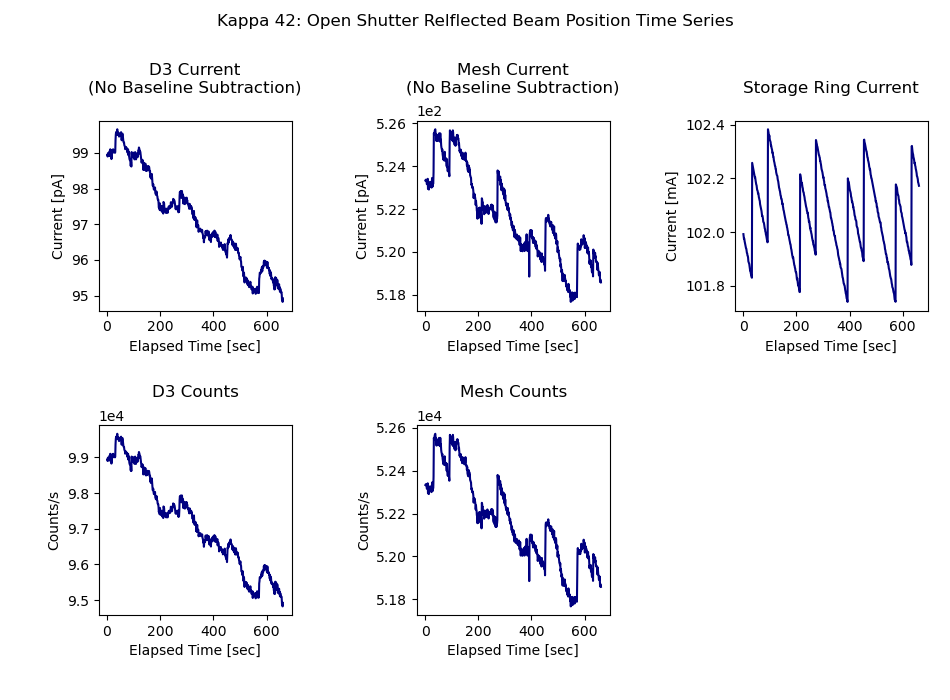

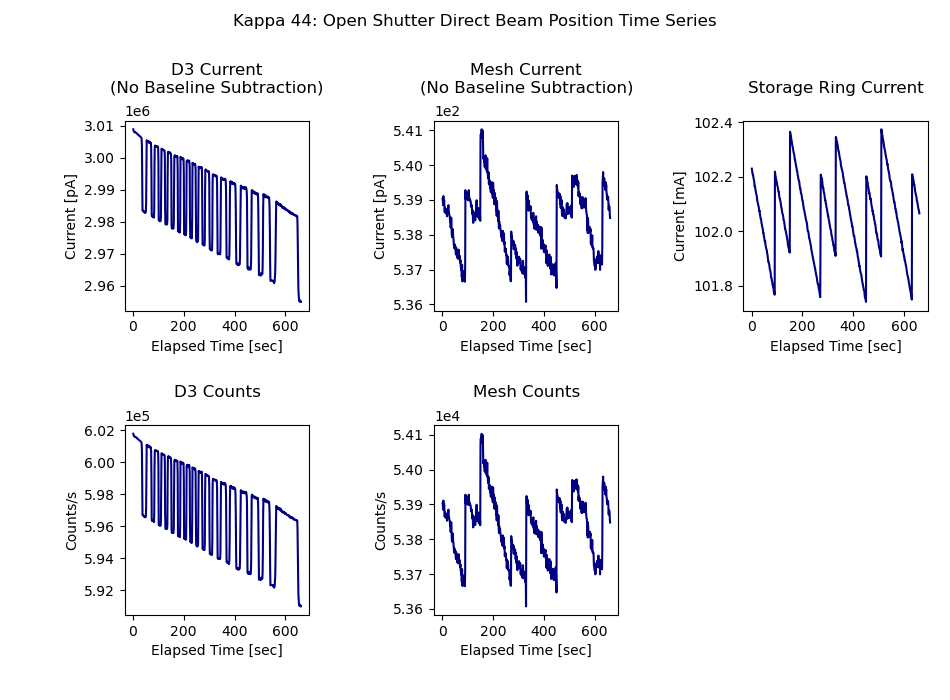

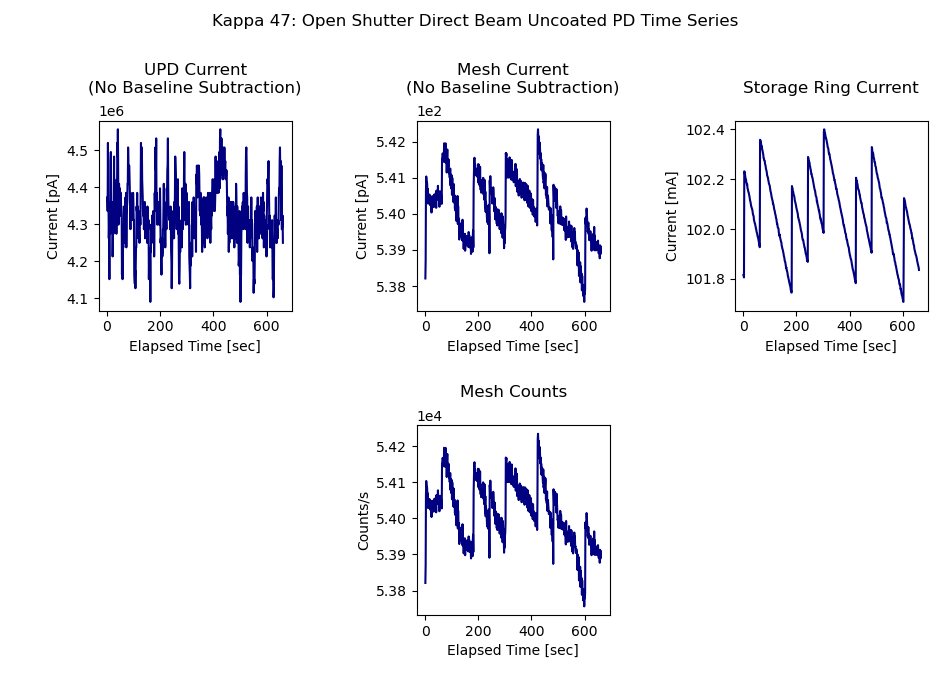

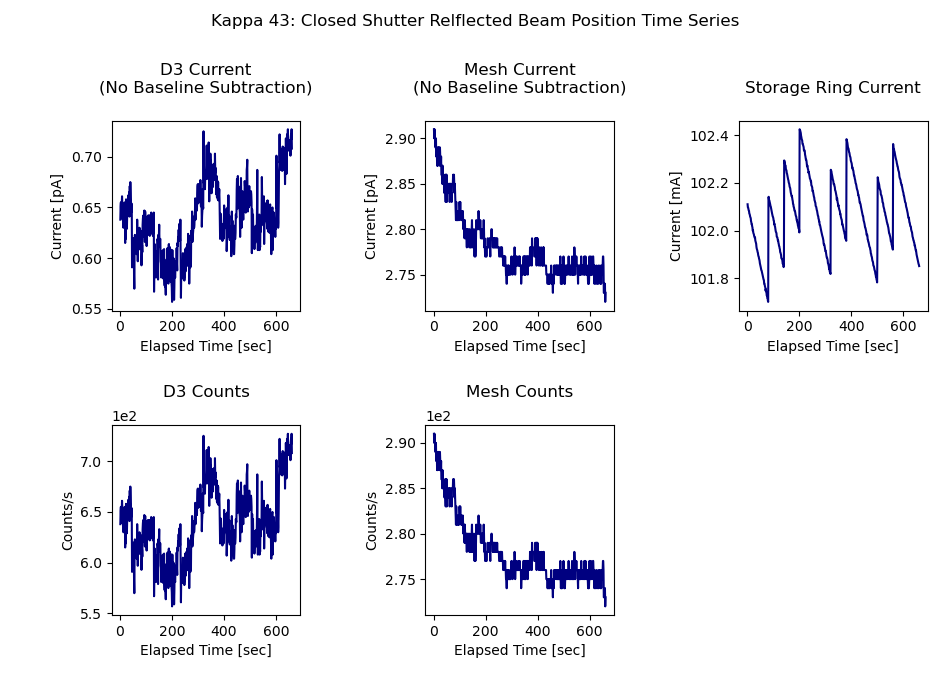

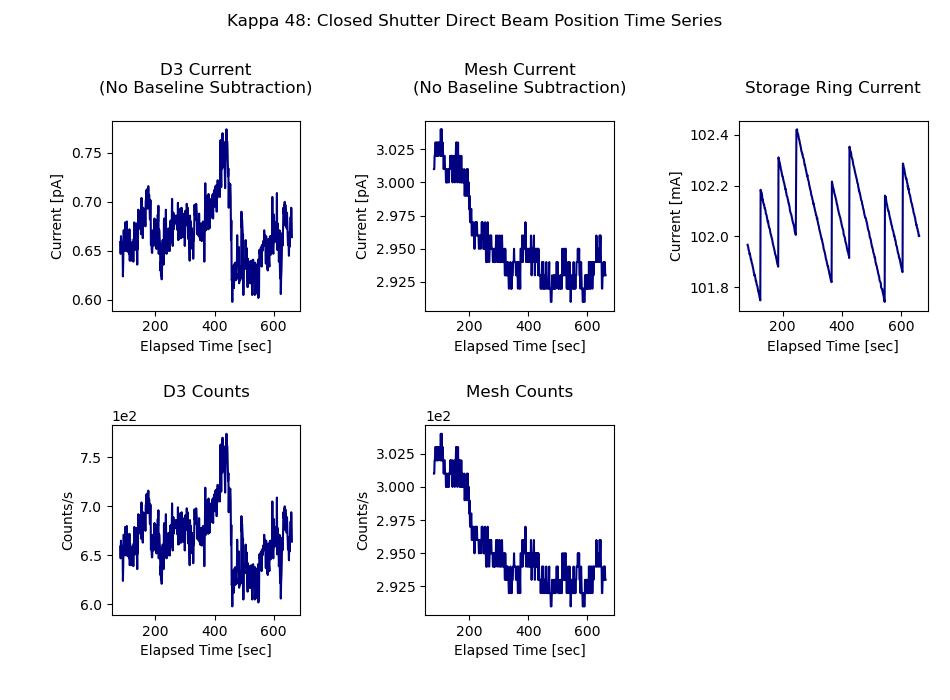

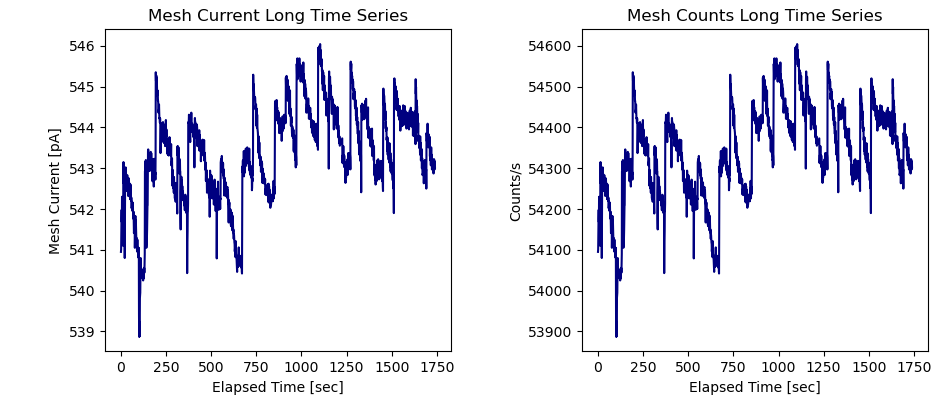

In [5]:
#All currents are in Amps except storage loop current which is in mA
#-------------------------------------------------------------------------------------------------
#Kappa 42
#Open Shutter Relflected Beam Position Time Series
kappaNum = 42
kappaDesc = "Open Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K42_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K42_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K42_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K42_D3_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K42_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K42_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 43
#Closed Shutter Relflected Beam Position Time Series
kappaNum = 43
kappaDesc = "Closed Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K43_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K43_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K43_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K43_D3_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K43_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K43_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 44
#Open Shutter Direct Beam Position Time Series
kappaNum = 44
kappaDesc = "Open Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K44_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K44_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K44_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction) (Using Best Guess for Gain, because the gain in the meta data is clearly wrong)
detNum = 33
gain_K44 = 500
gain_unit_string_K44 = 'nA/V'

K44_D3_Current_No_BS = calc_current_given_gain(kappa(kappaNum),detNum,gain_K44,gain_unit_string_K44,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K44_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K44_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 48
#Closed Shutter Direct Beam Position Time Series
kappaNum = 48
kappaDesc = "Closed Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K48_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K48_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K48_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K48_D3_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K48_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K48_Storage_Loop_Current=data[1].d[d_index].data

#The time series started before the shutter was completely closed, so we start at index 73
K48_Positioner = K48_Positioner[73:]
K48_D3_Counts = K48_D3_Counts[73:]
K48_Mesh_Counts = K48_Mesh_Counts[73:]
K48_D3_Current_No_BS = K48_D3_Current_No_BS[73:]
K48_Mesh_Current_No_BS = K48_Mesh_Current_No_BS[73:]
K48_Storage_Loop_Current = K48_Storage_Loop_Current[73:]
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 47
#Open Shutter Direct Beam Uncoated PD Time Series
kappaNum = 47
kappaDesc = "Open Shutter Direct Beam Uncoated PD Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K47_Positioner =data[1].p[0].data

#Uncoated Photodiode Counts
#detNum = 63
#d_index = get_d_index(kappa(kappaNum),detNum)
#K47_UPD_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K47_Mesh_Counts=data[1].d[d_index].data

#Uncoated Photodiode Current
detNum = 63
d_index = get_d_index(kappa(kappaNum),detNum)
K47_UPD_Current=data[1].d[d_index].data

#Mesh Current (No Baseline Subtraction)
detNum = 31
K47_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current [mA]
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K47_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Mesh Current Long Time Series
MeshCurrentTable = Table.read('mesh_current.csv', format='ascii.csv')

TimesArray = np.array(MeshCurrentTable['Time'])
MeshCountArray = np.array(MeshCurrentTable['Mesh_Current'])

#Convert Times to elapsed seconds
TimesList = []
for i in range(np.size(TimesArray)):
    TimesList.append(get_sec(TimesArray[i]))
TimesArraySec = np.array(TimesList)

#Truncate both time and counts arrays at the turn of the hour
#The time is only recorded up to 60 minutes, before looping back to 0 minutes,
#but there was no real data before the turn of the 1st hour anyways because we forgot to open the main shutter for a while
#and we don't get to the turn of the second hour before the timeseries ends.

NewTimesArray = TimesArraySec[find_nearest(TimesArraySec, 0):]
NewTimesArray = NewTimesArray - NewTimesArray[0]

NewMeshCountArray = MeshCountArray[find_nearest(TimesArraySec, 0):]

#Now I truncate again at 1050 seconds elapsed time because I remember there being funny business that I knew I had to cut out.
#I pick 1050 seconds based on a plot from earlier versions of this code that is excluded here for brevity.
FinalTimesArray = NewTimesArray[find_nearest(NewTimesArray, 1050):]
FinalTimesArray = FinalTimesArray - FinalTimesArray[0]
LTS_Positioner = FinalTimesArray

FinalMeshCountArray = NewMeshCountArray[find_nearest(NewTimesArray, 1050):]
LTS_Mesh_Counts = FinalMeshCountArray

#Calculate the Current
#Reuse the mesh gain values from Kappa 48, the most recent Kappa time series
kappaNum = 48
detNum = 31
LTS_Mesh_Current_No_BS = calc_current_MeshTS(kappa(kappaNum),detNum,FinalMeshCountArray,subtract_baseline = False)
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------

#All currents are in Amps except for Storage loop currents, which are in mA
#-------------------------------------------------------------------------------------------------
#Kappa 42
#Open Shutter Relflected Beam Position Time Series
OS_R_Positioner = np.array(K42_Positioner)
OS_R_D3_Counts = np.array(K42_D3_Counts)
OS_R_Mesh_Counts = np.array(K42_Mesh_Counts)
OS_R_D3_Current = np.array(K42_D3_Current_No_BS)
OS_R_Mesh_Current = np.array(K42_Mesh_Current_No_BS)
OS_R_Storage_Loop_Current = np.array(K42_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 43
#Closed Shutter Relflected Beam Position Time Series
CS_R_Positioner = np.array(K43_Positioner)
CS_R_D3_Counts = np.array(K43_D3_Counts)
CS_R_Mesh_Counts = np.array(K43_Mesh_Counts)
CS_R_D3_Current = np.array(K43_D3_Current_No_BS)
CS_R_Mesh_Current = np.array(K43_Mesh_Current_No_BS)
CS_R_Storage_Loop_Current = np.array(K43_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 44
#Open Shutter Direct Beam Position Time Series
OS_D_Positioner = np.array(K44_Positioner)
OS_D_D3_Counts = np.array(K44_D3_Counts)
OS_D_Mesh_Counts = np.array(K44_Mesh_Counts)
OS_D_D3_Current = np.array(K44_D3_Current_No_BS)
OS_D_Mesh_Current = np.array(K44_Mesh_Current_No_BS)
OS_D_Storage_Loop_Current = np.array(K44_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 48
#Closed Shutter Direct Beam Position Time Series
CS_D_Positioner = np.array(K48_Positioner)
CS_D_D3_Counts = np.array(K48_D3_Counts)
CS_D_Mesh_Counts = np.array(K48_Mesh_Counts)
CS_D_D3_Current = np.array(K48_D3_Current_No_BS)
CS_D_Mesh_Current = np.array(K48_Mesh_Current_No_BS)
CS_D_Storage_Loop_Current = np.array(K48_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 47
#Open Shutter Direct Beam Uncoated PD Time Series
OS_UPD_Positioner = np.array(K47_Positioner)
OS_UPD_Mesh_Counts = np.array(K47_Mesh_Counts)
OS_UPD_Current = np.array(K47_UPD_Current)
OS_UPD_Mesh_Current = np.array(K47_Mesh_Current_No_BS)
OS_UPD_Storage_Loop_Current = np.array(K47_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Mesh Current Long Time Series
LTS_Positioner = np.array(LTS_Positioner)
LTS_Mesh_Counts = np.array(LTS_Mesh_Counts)
LTS_Mesh_Current = np.array(LTS_Mesh_Current_No_BS)
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 42
#Open Shutter Relflected Beam Position Time Series
KappaNum = 42
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 44
#Open Shutter Direct Beam Position Time Series
KappaNum = 44
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Kappa 47
#Open Shutter Direct Beam Uncoated PD Time Series
KappaNum = 47
KappaDesc = "Open Shutter Direct Beam Uncoated PD Time Series"
DetName = "UPD"
Positioner = OS_UPD_Positioner
MeshCounts = OS_UPD_Mesh_Counts
DetCurrent = OS_UPD_Current
MeshCurrent = OS_UPD_Mesh_Current
StorageLoopCurrent = OS_UPD_Storage_Loop_Current
SaveName = False

PlotGraphsUPD(KappaNum,KappaDesc,DetName,Positioner,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 43
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 43
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Kappa 48
#Closed Shutter Direct Beam Position Time Series
KappaNum = 48
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Long Mesh Time Series
f, ax = plt.subplots(1, 2)
#plt.clf()
ax[0].plot(LTS_Positioner,LTS_Mesh_Current/1e-12, color="navy")
ax[0].set_title("Mesh Current Long Time Series", loc = 'center')
ax[0].set_xlabel('Elapsed Time [sec]')
ax[0].set_ylabel('Mesh Current [pA]')

ax[1].plot(LTS_Positioner,LTS_Mesh_Counts, color="navy")
ax[1].set_title("Mesh Counts Long Time Series", loc = 'center')
ax[1].set_xlabel('Elapsed Time [sec]')
ax[1].set_ylabel('Counts/s')
#ax.legend()
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(9.5, 4)
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Printing Kappa 42 Info
#Open Shutter Relflected Beam Position Time Series
KappaNum = 42
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("_________________________________________________________________________________________________")
print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 44 Info
#Open Shutter Direct Beam Position Time Series
KappaNum = 44
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)


print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

Gain = 500
Gain_unit_string = 'nA/V'

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

#print_SRS_parameters_K44(data,KappaNum,KappaDesc,Gain,Gain_unit_string)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 47 Info
#Open Shutter Direct Beam Uncoated PD Time Series
KappaNum = 47
KappaDesc = "Open Shutter Direct Beam Uncoated PD Time Series"
DetName = "UPD"
Positioner = OS_UPD_Positioner
MeshCounts = OS_UPD_Mesh_Counts
#DetCounts = OS_UPD_Counts
DetCurrent = OS_UPD_Current
MeshCurrent = OS_UPD_Mesh_Current
StorageLoopCurrent = OS_UPD_Storage_Loop_Current
SaveName = False

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parametersUPD(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  ? [?]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 43 Info
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 43
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 48 Info
#Closed Shutter Direct Beam Position Time Series
KappaNum = 48
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Long Time Series Info

KappaNum = 47 #The most recent time series with metadata
Positioner = LTS_Positioner
MeshCounts = LTS_Mesh_Counts
MeshCurrent = LTS_Mesh_Current

SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Long Mesh Current Time Series")
print("-------------------------------------------------------------------------")

print_SRS_parametersLTS(data,KappaNum)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  N/A")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: N/A")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")



_________________________________________________________________________________________________
Kappa 67: Open Shutter Relflected Beam Position Time Series
-------------------------------------------------------------------------
Beam Parameters:

RSXS Branch, MEG
---------------------------------------------------
Slit:                     200.0 [um] (29idb:Slit4Vt2.C) (slit3D size)
Polarization:             H      (ID29:ActualMode) (polarization)
Desired Photon Energy:    490.0 [eV] (29idmono:ENERGY_SP) (Desired Photon Energy)
Calculated Photon Energy: 490.001 +/- 0.005 [eV](29idmono:ENERGY_MON) (Calculated Photon Energy)
-------------------------------------------------------------------------
Gain Settings:

SRS_3 (D3 Photodiode)
---------------------------------------------------
Gain:         1.0 [pA/V] (29idd:A3sens_num.VAL, 29idd:A3sens_unit.VAL) (SRS_3 Gain Value, SRS_3 Gain Unit)
Offset:       -7.0 [?] (29idd:A3off_u_put.VAL)                     (SRS_3 Offset Value)
Offset 

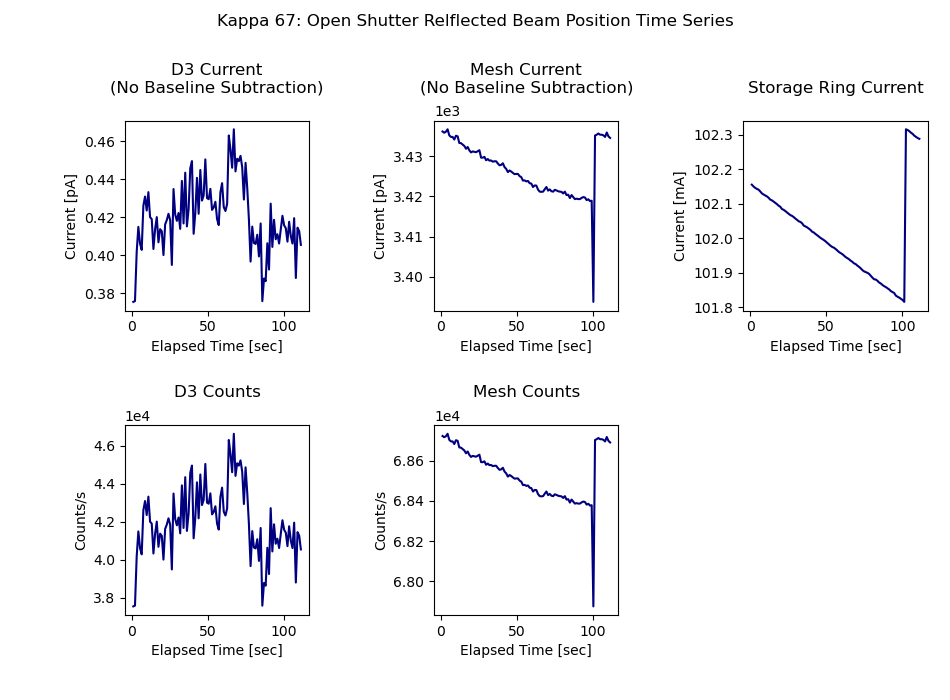

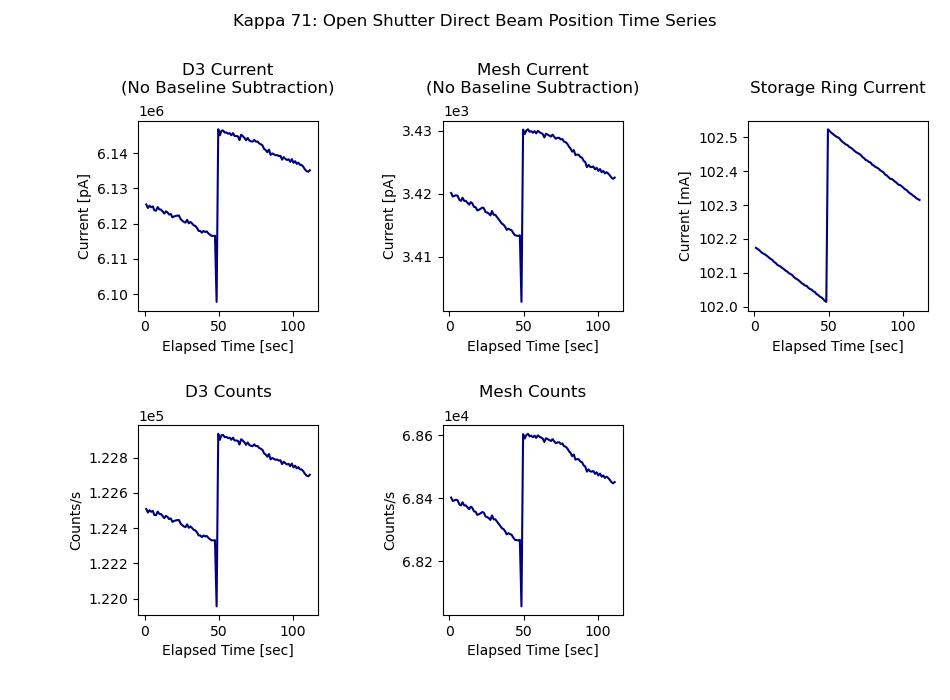

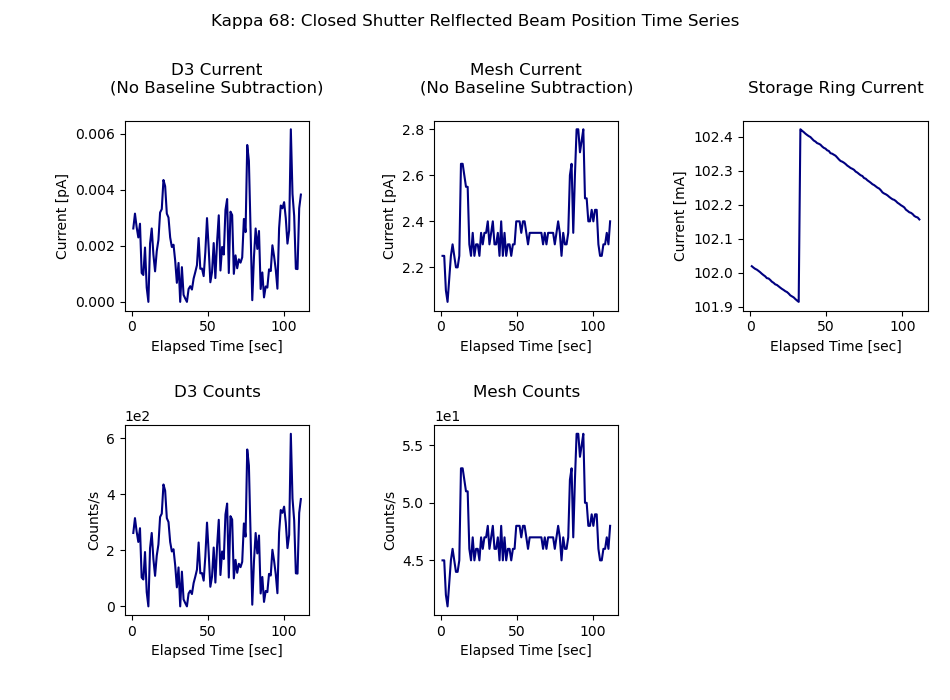

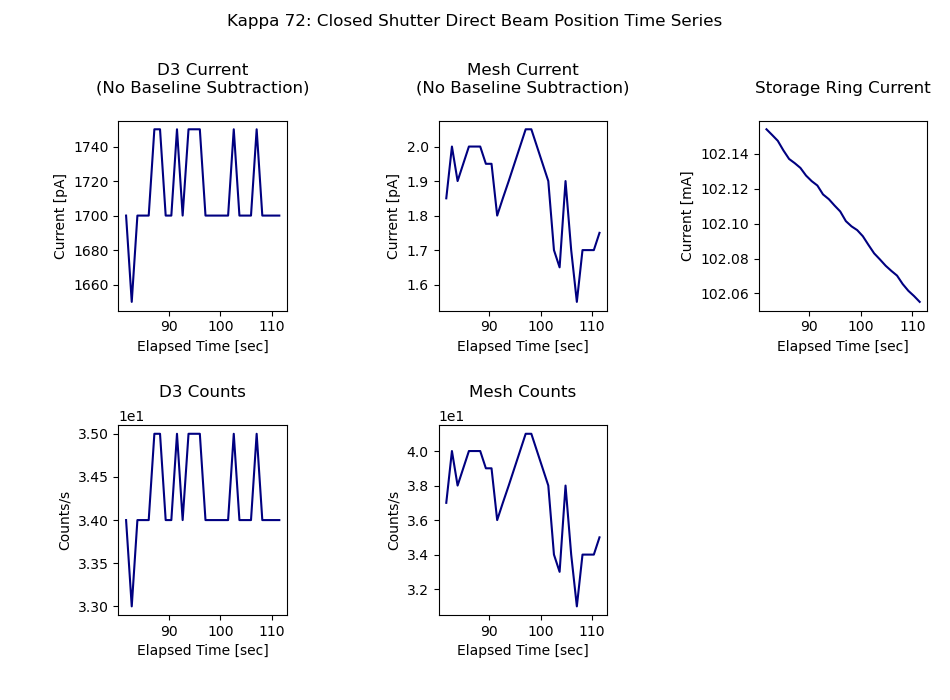

In [6]:
#All currents are in Amps except storage loop current which is in mA
#-------------------------------------------------------------------------------------------------
#Kappa 67
#Open Shutter Relflected Beam Position Time Series
kappaNum = 67
kappaDesc = "Open Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K67_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K67_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K67_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K67_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K67_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K67_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 68
#Closed Shutter Relflected Beam Position Time Series
kappaNum = 68
kappaDesc = "Closed Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K68_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K68_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K68_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K68_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K68_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K68_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 71
#Open Shutter Direct Beam Position Time Series
kappaNum = 71
kappaDesc = "Open Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K71_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K71_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K71_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K71_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K71_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K71_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 72
#Closed Shutter Direct Beam Position Time Series
kappaNum = 72
kappaDesc = "Closed Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K72_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K72_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K72_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K72_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K72_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K72_Storage_Loop_Current=data[1].d[d_index].data

#The time series started before the shutter was completely closed, so we start at index 73
K72_Positioner = K72_Positioner[73:]
K72_D3_Counts = K72_D3_Counts[73:]
K72_Mesh_Counts = K72_Mesh_Counts[73:]
K72_D3_Current_No_BS = K72_D3_Current_No_BS[73:]
K72_Mesh_Current_No_BS = K72_Mesh_Current_No_BS[73:]
K72_Storage_Loop_Current = K72_Storage_Loop_Current[73:]
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------

#All currents are in Amps except for Storage loop currents, which are in mA
#-------------------------------------------------------------------------------------------------
#Kappa 67
#Open Shutter Relflected Beam Position Time Series
OS_R_Positioner = np.array(K67_Positioner)
OS_R_D3_Counts = np.array(K67_D3_Counts)
OS_R_Mesh_Counts = np.array(K67_Mesh_Counts)
OS_R_D3_Current = np.array(K67_D3_Current_No_BS)
OS_R_Mesh_Current = np.array(K67_Mesh_Current_No_BS)
OS_R_Storage_Loop_Current = np.array(K67_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 68
#Closed Shutter Relflected Beam Position Time Series
CS_R_Positioner = np.array(K68_Positioner)
CS_R_D3_Counts = np.array(K68_D3_Counts)
CS_R_Mesh_Counts = np.array(K68_Mesh_Counts)
CS_R_D3_Current = np.array(K68_D3_Current_No_BS)
CS_R_Mesh_Current = np.array(K68_Mesh_Current_No_BS)
CS_R_Storage_Loop_Current = np.array(K68_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 71
#Open Shutter Direct Beam Position Time Series
OS_D_Positioner = np.array(K71_Positioner)
OS_D_D3_Counts = np.array(K71_D3_Counts)
OS_D_Mesh_Counts = np.array(K71_Mesh_Counts)
OS_D_D3_Current = np.array(K71_D3_Current_No_BS)
OS_D_Mesh_Current = np.array(K71_Mesh_Current_No_BS)
OS_D_Storage_Loop_Current = np.array(K71_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 72
#Closed Shutter Direct Beam Position Time Series
CS_D_Positioner = np.array(K72_Positioner)
CS_D_D3_Counts = np.array(K72_D3_Counts)
CS_D_Mesh_Counts = np.array(K72_Mesh_Counts)
CS_D_D3_Current = np.array(K72_D3_Current_No_BS)
CS_D_Mesh_Current = np.array(K72_Mesh_Current_No_BS)
CS_D_Storage_Loop_Current = np.array(K72_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Plotting Kappa 67
#Open Shutter Relflected Beam Position Time Series
KappaNum = 67
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 71
#Open Shutter Direct Beam Position Time Series
KappaNum = 71
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 68
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 68
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Kappa 72
#Closed Shutter Direct Beam Position Time Series
KappaNum = 72
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Printing Kappa 67 Info
#Open Shutter Relflected Beam Position Time Series
KappaNum = 67
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("_________________________________________________________________________________________________")
print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 71 Info
#Open Shutter Direct Beam Position Time Series
KappaNum = 71
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)


print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")


#-------------------------------------------------------------------------------------------------
#Printing Kappa 68 Info
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 68
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 72 Info
#Closed Shutter Direct Beam Position Time Series
KappaNum = 72
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")



Kappa 36: Open Shutter Direct Beam Position Time Series 551.2 eV
-------------------------------------------------------------------------
Beam Parameters:

RSXS Branch, MEG
---------------------------------------------------
Slit:                     200.0 [um] (29idb:Slit4Vt2.C) (slit3D size)
Polarization:             H      (ID29:ActualMode) (polarization)
Desired Photon Energy:    551.2 [eV] (29idmono:ENERGY_SP) (Desired Photon Energy)
Calculated Photon Energy: 551.2 +/- 0.005 [eV](29idmono:ENERGY_MON) (Calculated Photon Energy)
-------------------------------------------------------------------------
Gain Settings:

SRS_3 (D3 Photodiode)
---------------------------------------------------
Gain:         5.0 [uA/V] (29idd:A3sens_num.VAL, 29idd:A3sens_unit.VAL) (SRS_3 Gain Value, SRS_3 Gain Unit)
Offset:       -4.0 [?] (29idd:A3off_u_put.VAL)                     (SRS_3 Offset Value)
Offset Gain*: 500.0 [pA] (29idd:A3offset_num.VAL, 29idd:A3offset_unit.VAL) (SRS_3 Offset Gain Value, S

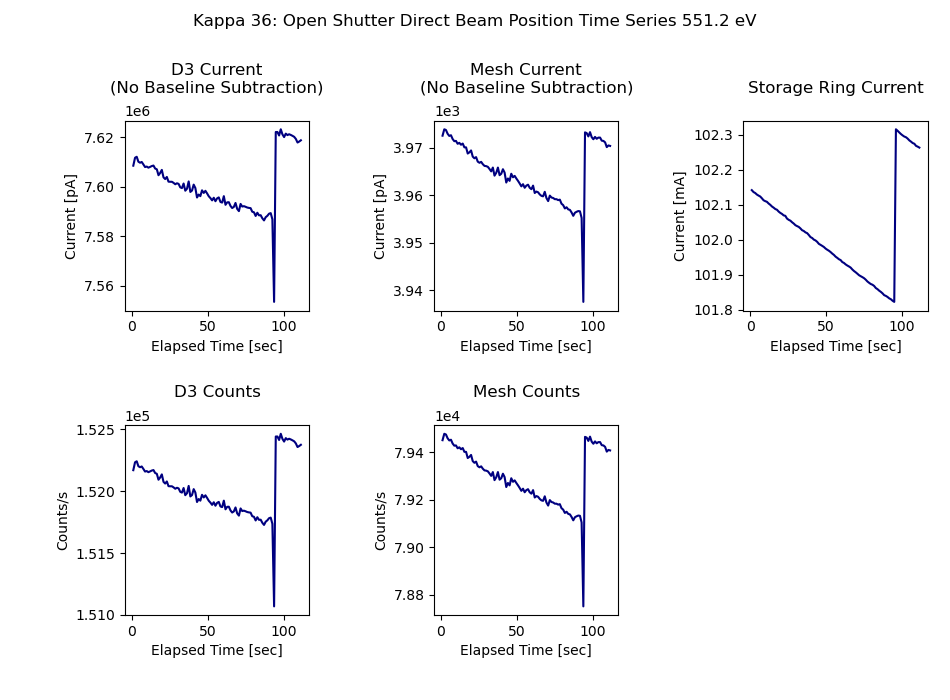

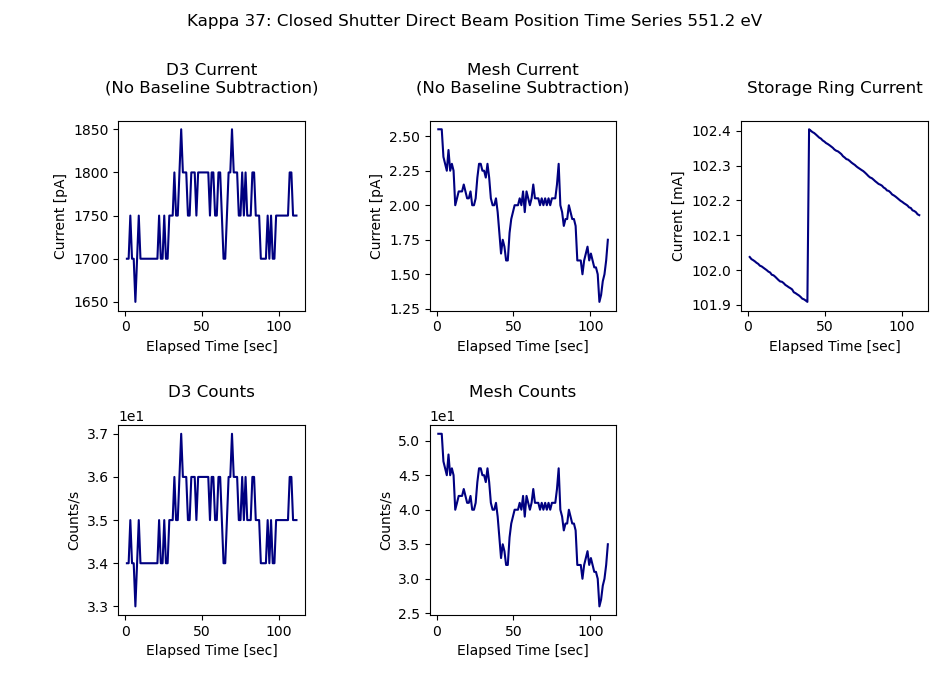

In [7]:
#-------------------------------------------------------------------------------------------------
#Kappa 36
#Open Shutter Direct Beam Position Time Series 551.2 eV
kappaNum = 36
kappaDesc = "Open Shutter Direct Beam Position Time Series 551.2 eV"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K36_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K36_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K36_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K36_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K36_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K36_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 37
#Closed Shutter Direct Beam Position Time Series 551.2 eV
kappaNum = 37
kappaDesc = "Closed Shutter Direct Beam Position Time Series 551.2 eV"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K37_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K37_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K37_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K37_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K37_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K37_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------

#All currents are in Amps except for Storage loop currents, which are in mA
#-------------------------------------------------------------------------------------------------
#Kappa 36
#Open Shutter Direct Beam Position Time Series 551.2 eV
OS_D_Positioner = np.array(K36_Positioner)
OS_D_D3_Counts = np.array(K36_D3_Counts)
OS_D_Mesh_Counts = np.array(K36_Mesh_Counts)
OS_D_D3_Current = np.array(K36_D3_Current_No_BS)
OS_D_Mesh_Current = np.array(K36_Mesh_Current_No_BS)
OS_D_Storage_Loop_Current = np.array(K36_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 37
#Closed Shutter Direct Beam Position Time Series 551.2 eV
CS_D_Positioner = np.array(K37_Positioner)
CS_D_D3_Counts = np.array(K37_D3_Counts)
CS_D_Mesh_Counts = np.array(K37_Mesh_Counts)
CS_D_D3_Current = np.array(K37_D3_Current_No_BS)
CS_D_Mesh_Current = np.array(K37_Mesh_Current_No_BS)
CS_D_Storage_Loop_Current = np.array(K37_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Plotting Kappa 36
#Open Shutter Direct Beam Position Time Series
KappaNum = 36
KappaDesc = "Open Shutter Direct Beam Position Time Series 551.2 eV"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Kappa 37
#Closed Shutter Direct Beam Position Time Series
KappaNum = 37
KappaDesc = "Closed Shutter Direct Beam Position Time Series 551.2 eV"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------


## Determining Photon Flux at 490.5 eV

$$\Phi_{\gamma} = \frac{cI_{D3}}{R_{UPD} E_{\gamma} q_{e^-}}$$

In [8]:
def DeterminePhotonFlux(C,Err_C,I,Err_I,R,Err_R,E,Err_E):
    q_e = sp.constants.e

    PhotonFlux = (C*I)/(R*E*q_e)

    #Determining the Error (Ignoring the possible covariance between R_cal and E_gamma)
    Var1 = ((1/(E*q_e))*(I/R)*Err_C)**2
    Var2 = ((1/(E*q_e))*(C/R)*Err_I)**2
    Var3 = ((-1/(E*q_e))*(C*I/(R**2))*Err_R)**2
    Var4 = ((-1/((E**2)*q_e))*(C*I/R)*Err_E)**2
    
    Err_PhotonFlux = math.sqrt(Var1+Var2+Var3+Var4)
    
    return PhotonFlux, Err_PhotonFlux

In [15]:
#Find Dark Subtracted Reflected Beam Current
OS_R_D3_Current = np.array(K42_D3_Current_No_BS)
CS_R_D3_Current = np.array(K43_D3_Current_No_BS)

MeanDarkCurrentD3_R = np.mean(CS_R_D3_Current)
StdMeanDarkCurrentD3_R = np.std(CS_R_D3_Current)

OS_R_D3_DS_Current = OS_R_D3_Current - MeanDarkCurrentD3_R

MeanDarkSubtractedCurrentD3_R = np.mean(OS_R_D3_DS_Current)
StdMeanDarkSubtractedCurrentD3_R = np.std(OS_R_D3_DS_Current)

MeanDarkSubtractedCurrentD3_R_nA = MeanDarkSubtractedCurrentD3_R/1e-9
StdMeanDarkSubtractedCurrentD3_R_nA = StdMeanDarkSubtractedCurrentD3_R/1e-9

MeanDarkSubtractedCurrentD3_R_pA = MeanDarkSubtractedCurrentD3_R/1e-12
StdMeanDarkSubtractedCurrentD3_R_pA = StdMeanDarkSubtractedCurrentD3_R/1e-12


MeanOS_R_D3_Current_pA = np.mean(OS_R_D3_Current)/1e-12
StdOS_R_D3_Current_pA = np.std(OS_R_D3_Current)/1e-12

MeanDarkCurrentD3_R_nA = MeanDarkCurrentD3_R/1e-9
StdMeanDarkCurrentD3_R_nA = StdMeanDarkCurrentD3_R/1e-9

MeanDarkCurrentD3_R_pA = MeanDarkCurrentD3_R/1e-12
StdMeanDarkCurrentD3_R_pA = StdMeanDarkCurrentD3_R/1e-12

print("D-3 Photodiode Open Shutter Current (490.5 eV, Reflected Position)   : " + str(round(MeanOS_R_D3_Current_pA,2)) + " +/- " + str(round(StdOS_R_D3_Current_pA,2)) + " [pA]")
print("D-3 Photodiode Closed Shutter Current (490.5 eV, Reflected Position) : " + str(round(MeanDarkCurrentD3_R_pA,2)) + " +/- " + str(round(StdMeanDarkCurrentD3_R_pA,2)) + " [pA]")
print("")
print("D-3 Photodiode Dark Subtracted Current (490.5 eV, Reflected Position): " + str(round(MeanDarkSubtractedCurrentD3_R_pA,1)) + " +/- " + str(round(StdMeanDarkSubtractedCurrentD3_R_pA,1)) + " [pA]")

D-3 Photodiode Open Shutter Current (490.5 eV, Reflected Position)   : 97.16 +/- 1.33 [pA]
D-3 Photodiode Closed Shutter Current (490.5 eV, Reflected Position) : 0.64 +/- 0.04 [pA]

D-3 Photodiode Dark Subtracted Current (490.5 eV, Reflected Position): 96.5 +/- 1.3 [pA]


In [22]:
#Supplying Known and Calculated Constants

#Calibration Coefficient at from PhotodiodeCalibration1.ipynb 
C = 1.1845405519720842 #490.0 eV calibration with 1 outlier removed
Err_C = 0.0040558789989205025 #half range error with 1 outlier removed

#Photodiode Responsivity at 490.5 eV from PhotodiodeResponsivityCalculation.ipynb 
R = 0.27138859346578026 #From a cubic splines fit of the AXUV100 Responsivity Curve provided by John
Err_R = 0.002313939712164259 #Uncertainty from the maximum difference between provided curve value and NIST theoretical value.

#Beam Energy
E = 490.5 #Set and Calculated Energy
Err_E = 0.01 #Uncertainty from both McChesney paper at this energy, and metadata of calculated beam energy from PD .mda files.

#D-3 Photodiode Current
I = MeanDarkSubtractedCurrentD3_R # Calculated Above
Err_I = StdMeanDarkSubtractedCurrentD3_R # sigma_(I_D3) An underestimate due to beam fluctuations, but we'll account for that... 
#... by applying an error to the final photon flux



In [43]:
#Determine Photon Flux at 490.5 eV

D3_PhotonFlux, Err_D3_PhotonFlux = DeterminePhotonFlux(C,Err_C,I,Err_I,R,Err_R,E,Err_E)
D3_Sigma_A = Err_D3_PhotonFlux
percentErr_D3_Sigma_A = (D3_Sigma_A/D3_PhotonFlux)*100

print("D-3 Photodiode Current (490.5 eV, Reflected Position): " + str(round(MeanDarkSubtractedCurrentD3_R_pA,1)) + " +/- " + str(round(StdMeanDarkSubtractedCurrentD3_R_pA,1)) + " [pA]")
print("")
print("D3 Photodiode Photon Flux (490.5 eV): " + str("{:.4}".format(D3_PhotonFlux)) + " [photons/sec]")
print("Sigma_A: " + str("{:.4}".format(Err_D3_PhotonFlux)) + " [photons/sec]")
print("Percent Error (Sigma_A): " + str("{:.3}".format(percentErr_D3_Sigma_A)) + "%")


D-3 Photodiode Current (490.5 eV, Reflected Position): 96.5 +/- 1.3 [pA]

D3 Photodiode Photon Flux (490.5 eV): 5.361e+06 [photons/sec]
Sigma_A: 8.863e+04 [photons/sec]
Percent Error (Sigma_A): 1.65%


## Determining The Error in Photon Flux Due to Beam Fluctuations $\sigma_{Beam}$

Begin by composing the mosaic here.

In [26]:
#Loading in Master Hots Array
HotsArray = np.loadtxt('SteadyStateDataSets/MasterHotsArray.csv', delimiter=',')

SetNamesList = ['X0_Y0','X0_YM1','X0_YM2','X0_YM3','X0_YP1','X0_YP2','X0_YP3','XM2_Y0','XM2_YM1','XM2_YP1','XP2_Y0','XP2_YM1','XP2_YP1','XP4_Y0']

#Make the Offset Dictionary
OffsetDict = {}

for SetName in SetNamesList:
    Offset = 2
    OffsetDict.update({SetName:Offset})

#This frame has an offset of 3 for some reason. MeanFrameMedian=5.0 for this mosaic position where every other position has 4.0.
OffsetDict.update({'XM2_Y0':3}) 

#----------------------------------------------------------------------------------------------------------------------

#Loading in Saved Dictionaries
with open('MeanExpTimeDict.pkl', 'rb') as f:
    MeanExpTimeDict = pickle.load(f)
    
with open('NumFrameCountDict.pkl', 'rb') as f:
    NumFrameCountDict = pickle.load(f)
    
with open('FrameCountDict.pkl', 'rb') as f:
    FrameCountDict = pickle.load(f)

#Loading in the Final Frame Translation Dictionary
with open('TranslateX_Dict_GD4.pkl', 'rb') as f:
    TranslateX_Dict_GD4 = pickle.load(f)
        
with open('TranslateY_Dict_GD4.pkl', 'rb') as f:
    TranslateY_Dict_GD4 = pickle.load(f)

#----------------------------------------------------------------------------------------------------------------------

#Making Dictionaries
SumSignalFrameDict = {}
ErrSumSignalFrameDict = {}

SumDarkSubSignalFrameDict = {}
ErrSumDarkSubSignalFrameDict = {}

MeanDarkFrameDict = {}
SumDarkFrameDict = {}

HotsArrayDict = {}
CoordsDict = {}

for SetName in tqdm(SetNamesList):
    
    #making flux frame and error flux frame dictionaries
    LoadDirectory = 'SteadyStateDataSets/' + SetName + '/'
    
    #Loading in mean dark frames (in units of ADU)
    DarkFrameName = 'MeanCS_Dark'
    MeanDarkFrame = np.loadtxt(LoadDirectory + DarkFrameName + '.csv', delimiter=',')
    #Making sum dark frame (in units of ADU)
    MeanDarkFrame = (MeanDarkFrame - OffsetDict[SetName])*Gain #Convert from ADU to e-, and correcting for Offset
    Multiplier = FrameCountDict[SetName]
    SumDarkFrame = Multiplier*MeanDarkFrame
    
    
    #Loading in the non-dark subtracted sum signal frames (Tiles)
    SumSignalFrame = np.loadtxt(LoadDirectory + 'PrelimNoDarkSubSumSignalFrame4' + '.csv', delimiter=',')
    ErrorSumSignalFrame = np.loadtxt(LoadDirectory + 'PrelimNoDarkSubErrorSumSignalFrame4' + '.csv', delimiter=',')
    
    #Loading in the dark subtracted sum signal frames (Tiles)
    SumDarkSubSignalFrame = np.loadtxt(LoadDirectory + 'PrelimDarkSubSumSignalFrame4' + '.csv', delimiter=',')
    ErrorSumDarkSubSignalFrame = np.loadtxt(LoadDirectory + 'PrelimDarkSubErrorSumSignalFrame4' + '.csv', delimiter=',')
    
    MeanDarkFrameDict.update({SetName:MeanDarkFrame})
    SumDarkFrameDict.update({SetName:SumDarkFrame})
    
    SumSignalFrameDict.update({SetName:SumSignalFrame})
    ErrSumSignalFrameDict.update({SetName:ErrorSumSignalFrame})
    
    SumDarkSubSignalFrameDict.update({SetName:SumDarkSubSignalFrame})
    ErrSumDarkSubSignalFrameDict.update({SetName:ErrorSumDarkSubSignalFrame})
    
    
    HotsArrayDict.update({SetName:HotsArray})
    #making mosaic coordinates dictionary
    x_y = []
    SM1 = 'X'
    for s in SetName:
        if s.isdigit():
            if SM1 == 'P' or s == '0':
                Sign = 1
            if SM1 == 'M':
                Sign = -1
            x_y.append(int(Sign*int(s)))
        if s != 'X':
            SM1 = s
    CoordsDict.update({SetName:np.array(x_y)})

#----------------------------------------------------------------------------------------------------------------------

#Picking n as the lowest frame count for any set
FrameCountList = []
for SetName in SetNamesList:
    FrameCountList.append(FrameCountDict[SetName])
FrameCounts = np.array(FrameCountList)
n = np.amin(FrameCounts)

print("n: " + str(n))

  0%|          | 0/14 [00:00<?, ?it/s]

n: 206


In [27]:
def MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,FramesDict,CoordsDict,TranslateX_Dict,TranslateY_Dict):
    
    #Initalizing Empty Mosaic
    Mosaic = np.zeros((MosaicDimY*DimY,MosaicDimX*DimX))
    
    for SetName in tqdm(SetNamesList):
        Frame = FramesDict[SetName]
        
        Coords = -1*CoordsDict[SetName]
        
        MosaicX = Coords[0]
        MosaicY = Coords[1]
        
        if SetName in TranslateX_Dict:
            TranslateX = TranslateX_Dict[SetName]
            TranslateY = TranslateY_Dict[SetName]
        else:
            TranslateX = int(((MosaicX/2) + 2)*DimX)
            TranslateY = int((MosaicY + 3)*DimY)

        for xi in range(DimX):
            for yi in range(DimY):
                NewXi = xi + TranslateX
                NewYi = yi + TranslateY

                Mosaic[NewYi,NewXi] += Frame[yi,xi]
    
    return Mosaic

def ROItoPoints(ROI):
    
    x1 = ROI[0]
    y1 = ROI[2]

    x2 = ROI[1]
    y2 = ROI[2]
    
    x3 = ROI[1]
    y3 = ROI[3]
    
    x4 = ROI[0]
    y4 = ROI[3]
    
    x = [x1,x2,x3,x4]
    y = [y1,y2,y3,y4]
    
    return x, y

In [28]:
MosaicDimY = 7
MosaicDimX = 4
TranslateX_Dict = TranslateX_Dict_GD4
TranslateY_Dict = TranslateY_Dict_GD4

In [29]:
#Making n_k mosaic array (the mosaic of how many times a pixel in the mosaic has been counted)
n_k = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,NumFrameCountDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
#Making the combined hot pixels mosaic
HotsMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,HotsArrayDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)

#Adjusting n_k so that we don't divide by zero.
divide_n_k = np.zeros(np.shape(n_k))
divide_n_k = np.where(n_k < 1, 1, n_k) 

#<Mean Flux Mosaic>----------------------------------------------------------------
#Assembled from dark subtracted sum tiles
SumDarkSubSignalMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,SumDarkSubSignalFrameDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
SumDarkSubSignalMosaic = np.where(HotsMosaic > 0, 0, SumDarkSubSignalMosaic) #Zeroing hot pixels
#Get mean (per frame) dark subtracted signal by dividing by n_k (the number of frames summed to make each pixel's sum signal)
MeanDarkSubFluxMosaic = SumDarkSubSignalMosaic/divide_n_k
#In this case it's reasonable to say that all sets have the same exposure time, and that this exposure time is to within less
#than 10^-6 seconds of exactly 1 second. So, the mean per frame is also the mean flux.
#</Mean Flux Mosaic>---------------------------------------------------------------

#Finding the Mean Flux
MeanFlux = np.sum(MeanDarkSubFluxMosaic)

#<Error Determination>-------------------------------------------------------------
SumSignalsMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,SumSignalFrameDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
WeightedSumSignalMosaic = (n/divide_n_k)*SumSignalsMosaic #WeightedSumSignalMosaic made from NonDarkSubtracted SumSignal mosaic
WeightedSumSignalMosaic = np.where(HotsMosaic > 0, 0, WeightedSumSignalMosaic) #It is offset corrected but not dark subtracted

#Finding the Error in Mean Flux (before alignment uncertainty)
Sigma1 = (1/n)*(SigmaGain/Gain)*np.sum(WeightedSumSignalMosaic)
Sigma2 = (1/n)*np.sqrt(np.sum((np.sqrt(WeightedSumSignalMosaic + 0.75) + 1)**2))

ErrMeanFlux = math.sqrt((Sigma1**2) + (Sigma2**2)) #Error before alignment uncertainty
PercentError = ErrMeanFlux/MeanFlux #Error before alignment uncertainty
GainPercentError = SigmaGain/Gain

#</Error Determination>------------------------------------------------------------

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Check Value = -7.297 (should be -7.297 not -95.9)

Mean Flux: 2.029951e+08 [e-/s]
Sigma1: 3.711807e+04
Sigma2: 1.157923e+03
Error on Mean Flux (Before Alignment Uncertainty): 3.713612e+04 [e-/s]
Percent Error (Before Alignment Uncertainty): 0.018%
For Sanity Check, Percent Error on Gain: 0.014%


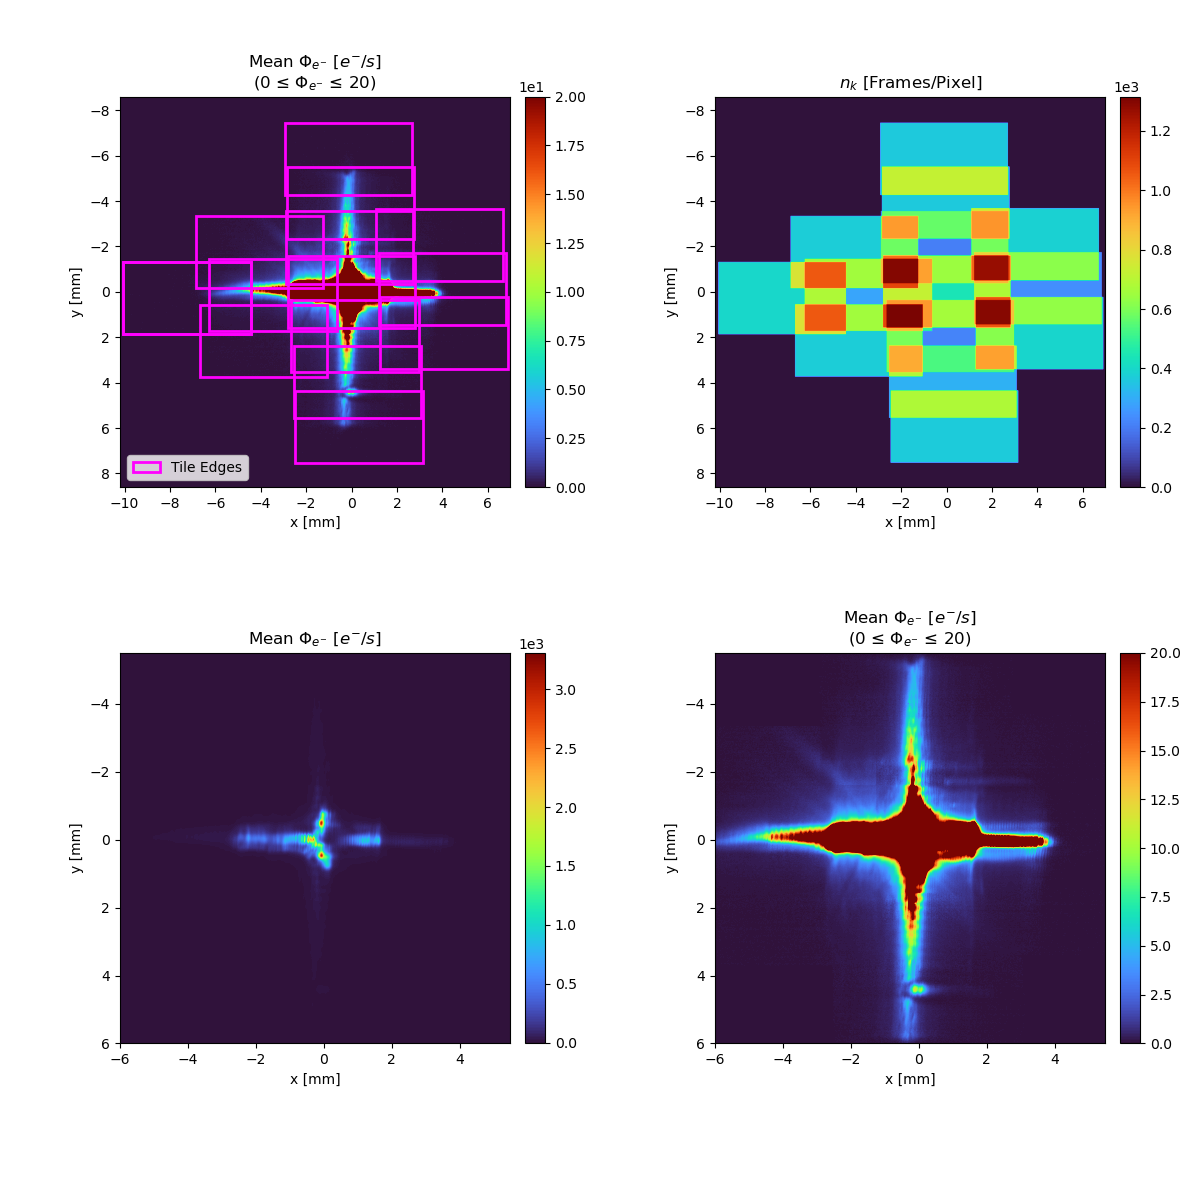

In [30]:
PercentErrorStr = str(round(PercentError*100,3))
GainPercentErrorStr = str(round(GainPercentError*100,3))

#print("Check Value1 = " +str(round(np.amin(SumDarkSignalsMosaic),2)) + " (should be -181 not -757)")
print("Check Value = " +str(round(np.amin(MeanDarkSubFluxMosaic),3)) + " (should be -7.297 not -95.9)")

print("")
print("Mean Flux: " + "{:e}".format(MeanFlux) + " [e-/s]")
print("Sigma1: " + "{:e}".format(Sigma1))
print("Sigma2: " + "{:e}".format(Sigma2))
print("Error on Mean Flux (Before Alignment Uncertainty): " + "{:e}".format(ErrMeanFlux) + " [e-/s]")
print("Percent Error (Before Alignment Uncertainty): " + PercentErrorStr + "%")
print("For Sanity Check, Percent Error on Gain: " + GainPercentErrorStr + "%")

#----------------------------------------------------------------------------------------------------------------------

Mosaic = MeanDarkSubFluxMosaic

#Making the Mosaic bigger in x
x_max_pixels = np.shape(Mosaic)[1]
y_max_pixels = np.shape(Mosaic)[0]
NewMosaic = np.zeros((y_max_pixels,x_max_pixels+2000))
NewMosaic[0:Mosaic.shape[0], 0:Mosaic.shape[1]] = Mosaic
Mosaic = NewMosaic

#Making n_k bigger in x
x_max_pixels = np.shape(n_k)[1]
y_max_pixels = np.shape(n_k)[0]
new_n_k = np.zeros((y_max_pixels,x_max_pixels+2000))
new_n_k[0:n_k.shape[0], 0:n_k.shape[1]] = n_k

#<Putting the axes of the plots in mm from center>
um_per_pixel = 2.9
x_center = TranslateX_Dict['X0_Y0'] + (DimX/2)
y_center = TranslateY_Dict['X0_Y0'] + (DimY/2)

x_min_mm = -1*x_center*um_per_pixel*0.001
y_min_mm = -1*y_center*um_per_pixel*0.001

x_max_pixels = np.shape(Mosaic)[1]
y_max_pixels = np.shape(Mosaic)[0]

x_max_mm = (x_max_pixels - x_center)*um_per_pixel*0.001
y_max_mm = (y_max_pixels - y_center)*um_per_pixel*0.001

extent = [x_min_mm, x_max_mm, y_min_mm, y_max_mm]
extent = [x_min_mm, x_max_mm, y_max_mm, y_min_mm]
#</>

f, ax = plt.subplots(2, 2)

#Plotting Top Left
im1 = ax[0,1].imshow(new_n_k, cmap='turbo', extent=extent)
divider1 = make_axes_locatable(ax[0,1])
cax1 = divider1.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
ax[0,1].set_xlabel('x [mm]')
ax[0,1].set_ylabel('y [mm]')
ax[0,1].set_title("$n_{k}$ [Frames/Pixel]", loc = 'center')
#ax[0,0].set_xlim([1300,7300])
#ax[0,0].set_ylim([830,6830])
ax[0,1].axis('equal')
#ax[0,0].set(xlim=(-10.2,10.2), ylim=(10.2,-10.2))
ax[0,1].set(xlim=(-10.2,7), ylim=(8.6,-8.6))
#plt.subplots_adjust(hspace = 0.35)

#Plotting Top Right
im2 = ax[0,0].imshow(Mosaic, cmap='turbo',extent=extent, vmin = 0, vmax = 20)
divider2 = make_axes_locatable(ax[0,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
for SetName in SetNamesList:
    Coords = -1*CoordsDict[SetName]
    
    MosaicX = Coords[0]
    MosaicY = Coords[1]
    
    if SetName in TranslateX_Dict:
        TranslateX = TranslateX_Dict[SetName]
        TranslateY = TranslateY_Dict[SetName]
    else:
        TranslateX = int(((MosaicX/2) + 2)*DimX)
        TranslateY = int((MosaicY + 3)*DimY)
            
    ROI = [TranslateX, TranslateX + DimX -1, TranslateY, TranslateY + DimY -1]
    ROImm = [(ROI[0]-x_center)*um_per_pixel*0.001,(ROI[1]-x_center)*um_per_pixel*0.001,(ROI[2]-y_center)*um_per_pixel*0.001,(ROI[3]-y_center)*um_per_pixel*0.001] 
    xROI, yROI = ROItoPoints(ROImm)

    ax[0,0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2)
ax[0,0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "Tile Edges")
ax[0,0].set_xlabel('x [mm]')
ax[0,0].set_ylabel('y [mm]')
#ax[0,1].set_title("Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')
ax[0,0].set_title(r"Mean $\Phi_{e^{-}}$ [$e^{-}/s$]"
               "\n" r"($0\ ≤\  \Phi_{e^{-}}\ ≤\ 20$)", loc = 'center')
#ax[0,1].set_xlim([1300,7300])
#ax[0,1].set_ylim([830,6830])
#ax[0,1].set_xlim([-10.1,10.1])
#ax[0,1].set_ylim([-10.1,10.1])
ax[0,0].axis('equal')
#ax[0,0].set(xlim=(-10.2,10.2), ylim=(10.2,-10.2))
ax[0,0].set(xlim=(-10.2,7), ylim=(8.6,-8.6))
ax[0,0].legend(loc='lower left')

#Plotting Bottom Left
im2 = ax[1,0].imshow(Mosaic, cmap='turbo', extent = extent)
divider2 = make_axes_locatable(ax[1,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[1,0].set_xlabel('x [mm]')
ax[1,0].set_ylabel('y [mm]')
ax[1,0].set_title("Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')
#ax[1,0].set_xlim([1300,7300])
#ax[1,0].set_ylim([830,6830])
ax[1,0].axis('equal')
#ax[1,0].set(xlim=(-7.5,7.5), ylim=(7.5,-7.5))
ax[1,0].set(xlim=(-6,5.5), ylim=(6,-5.5))


#Plotting Bottom Right
im2 = ax[1,1].imshow(Mosaic, cmap='turbo', extent = extent, vmin = 0, vmax = 20)
divider2 = make_axes_locatable(ax[1,1])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
#cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[1,1].set_xlabel('x [mm]')
ax[1,1].set_ylabel('y [mm]')
ax[1,1].set_title(r"Mean $\Phi_{e^{-}}$ [$e^{-}/s$]"
               "\n" r"($0\ ≤\  \Phi_{e^{-}}\ ≤\ 20$)", loc = 'center')

#ax[1,1].set_xlim([1300,7300])
#ax[1,1].set_ylim([830,6830])
ax[1,1].axis('equal')
#ax[1,1].set(xlim=(-7.5,7.5), ylim=(7.5,-7.5))
ax[1,1].set(xlim=(-6,5.5), ylim=(6,-5.5))

#plt.subplots_adjust(hspace = 0.35)
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()
#plt.savefig("MosaicTestPlot1a.png", dpi=200,bbox_inches='tight')
#Include projected extent of the d3 photodiode

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

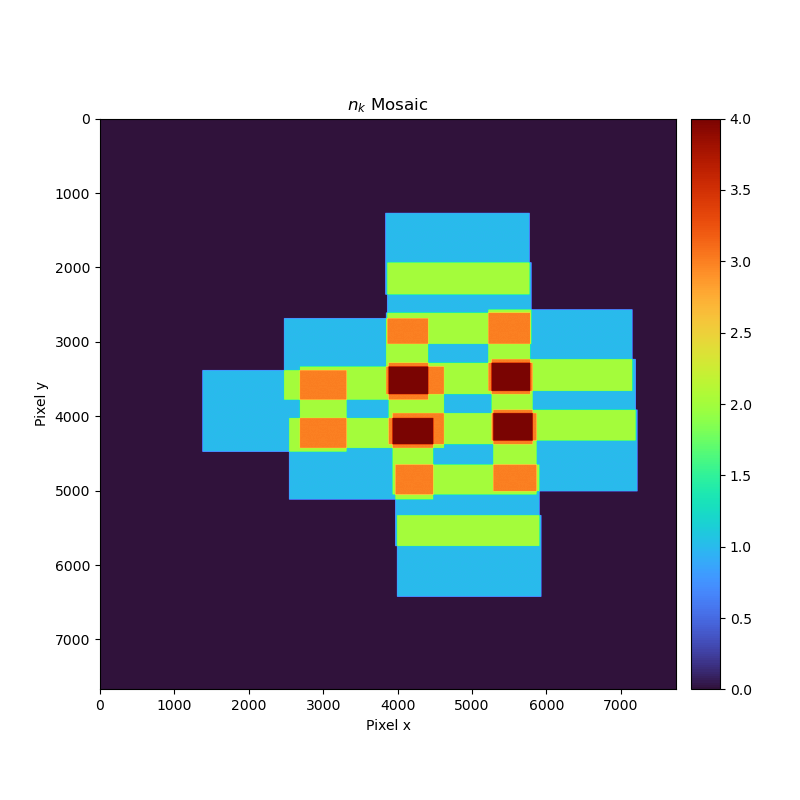

In [31]:
# Making Tile Overlap Mosaic
NumTileOverlapDict = {}

for SetName in tqdm(SetNamesList):
    NumTileFrame = np.zeros((DimY,DimX)) + 1 # Each tile is an array of just ones. When they're summed,
    #the mosaic with be the number of overlaping tiles at a given position.
    NumTileOverlapDict.update({SetName:NumTileFrame})

    #Making n_k mosaic array (the mosaic of how many times a pixel in the mosaic has been counted)

MosaicDimY = 7
MosaicDimX = 4
SetNamesList = SetNamesList
FramesDict = NumTileOverlapDict
CoordsDict = CoordsDict
TranslateX_Dict = TranslateX_Dict_GD4
TranslateY_Dict = TranslateY_Dict_GD4

n_tile_k = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,FramesDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)

            
f, ax = plt.subplots(1, 1)
im1 = ax.imshow(n_tile_k, cmap='turbo')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
ax.set_xlabel('Pixel x')
ax.set_ylabel('Pixel y')
ax.set_title("$n_{k}$ Mosaic", loc = 'center')
plt.subplots_adjust(hspace = 0.35)
figure = plt.gcf()
figure.set_size_inches(8, 8)
#SaveString = "Mean_Flux_Mosaic_A.png"
#plt.savefig(SaveString, dpi=750,bbox_inches='tight')
plt.show()

0.14632792502792763
0.48623904786488464
6.527590561082784
0.3298746336267224
0.1772315530951503
1.162755070378813
2.493650063266493
0.1790238873694485
0.27689341639800114
1.9249227190195943


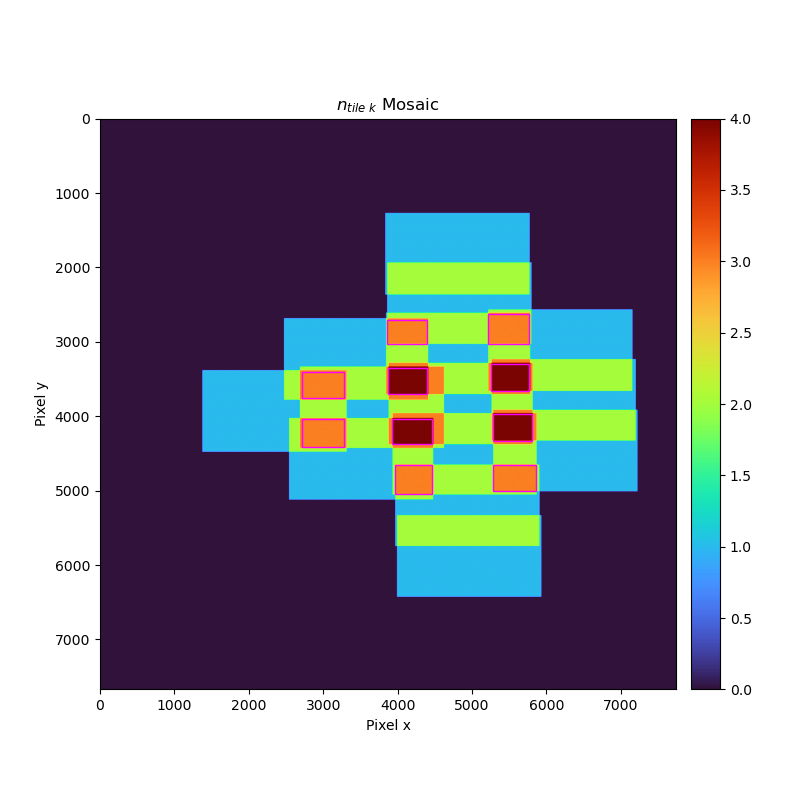

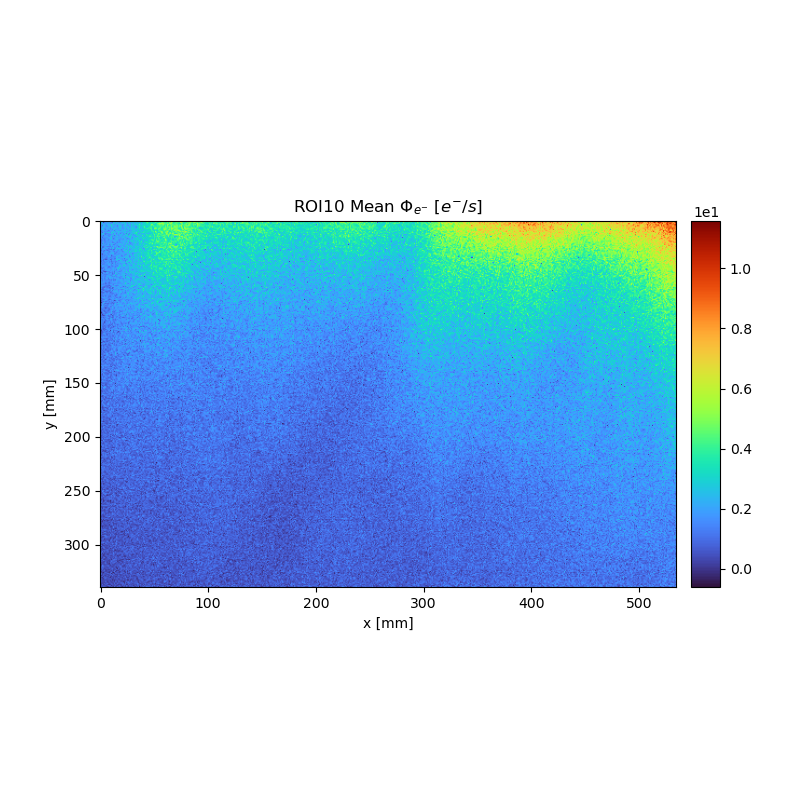

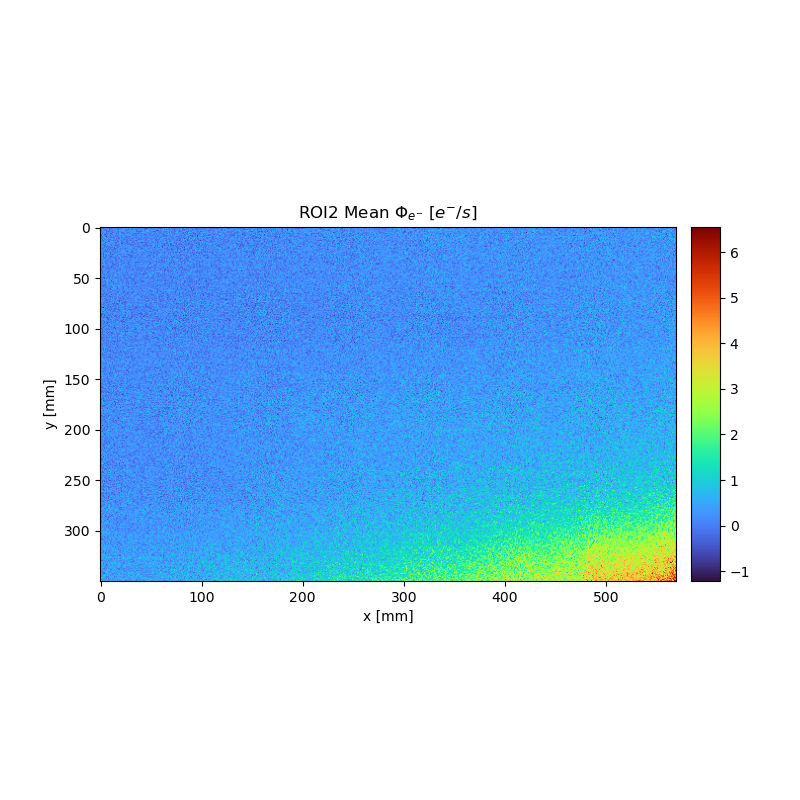

In [32]:
ROI1 = np.array([2710, 3280, 4040, 4420])
ROI2 = np.array([2710, 3280, 3400, 3750])
ROI3 = np.array([3875, 4400, 3345, 3700])
ROI4 = np.array([3860, 4400, 2700, 3030])
ROI5 = np.array([5220, 5760, 2625, 3030])
ROI6 = np.array([5260, 5770, 3300, 3660])
ROI7 = np.array([5280, 5800, 3970, 4330])
ROI8 = np.array([5285, 5855, 4660, 5010])
ROI9 = np.array([3970, 4465, 4660, 5050])
ROI10 = np.array([3930, 4465, 4035, 4375])

ROIs = [ROI1,ROI2,ROI3,ROI4,ROI5,ROI6,ROI7,ROI8,ROI9,ROI10]

f, ax = plt.subplots(1, 1)
im1 = ax.imshow(n_tile_k, cmap='turbo')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))

for ROI in ROIs:
    xROI, yROI = ROItoPoints(ROI)
    ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
    
    print(np.mean(MeanDarkSubFluxMosaic[ROI[2]:ROI[3],ROI[0]:ROI[1]]))

'''
xROI, yROI = ROItoPoints(ROI1)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI2)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI3)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI4)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI5)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI6)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI7)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI8)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI9)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
xROI, yROI = ROItoPoints(ROI10)
ax.fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=1)
'''

ax.set_xlabel('Pixel x')
ax.set_ylabel('Pixel y')
ax.set_title("$n_{tile\ k}$ Mosaic", loc = 'center')
plt.subplots_adjust(hspace = 0.35)
figure = plt.gcf()
figure.set_size_inches(8, 8)
#SaveString = "Mean_Flux_Mosaic_A.png"
#plt.savefig(SaveString, dpi=750,bbox_inches='tight')
plt.show()

ROI = ROI10

f, ax = plt.subplots(1, 1)
im1 = ax.imshow(MeanDarkSubFluxMosaic[ROI[2]:ROI[3],ROI[0]:ROI[1]], cmap='turbo')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title("ROI10 Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')

plt.subplots_adjust(hspace = 0.35)
figure = plt.gcf()
figure.set_size_inches(8, 8)
plt.show()

ROI = ROI2

f, ax = plt.subplots(1, 1)
im1 = ax.imshow(MeanDarkSubFluxMosaic[ROI[2]:ROI[3],ROI[0]:ROI[1]], cmap='turbo')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title("ROI2 Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')

plt.subplots_adjust(hspace = 0.35)
figure = plt.gcf()
figure.set_size_inches(8, 8)
plt.show()

In [34]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

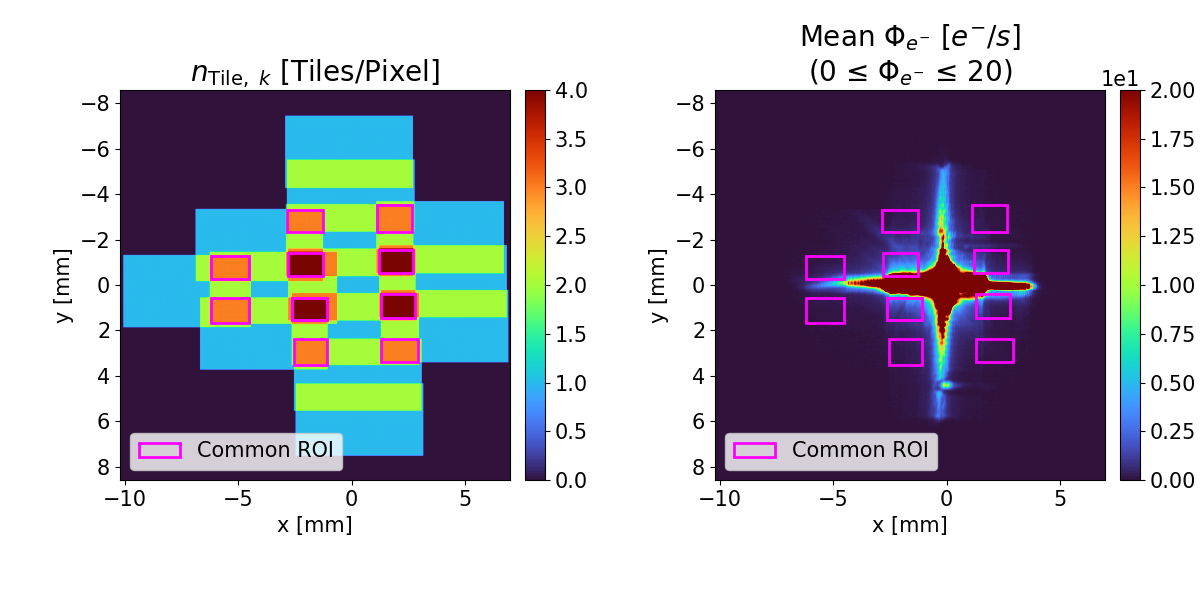

In [35]:
TranslateX_Dict = TranslateX_Dict_GD4
TranslateY_Dict = TranslateY_Dict_GD4
Mosaic = MeanDarkSubFluxMosaic

#Making the Mosaic bigger in x
x_max_pixels = np.shape(Mosaic)[1]
y_max_pixels = np.shape(Mosaic)[0]
NewMosaic = np.zeros((y_max_pixels,x_max_pixels+2000))
NewMosaic[0:Mosaic.shape[0], 0:Mosaic.shape[1]] = Mosaic
Mosaic = NewMosaic

#Making n_k bigger in x
x_max_pixels = np.shape(n_tile_k)[1]
y_max_pixels = np.shape(n_tile_k)[0]
new_n_k = np.zeros((y_max_pixels,x_max_pixels+2000))
new_n_k[0:n_tile_k.shape[0], 0:n_tile_k.shape[1]] = n_tile_k

#<Putting the axes of the plots in mm from center>
um_per_pixel = 2.9
x_center = TranslateX_Dict['X0_Y0'] + (DimX/2)
y_center = TranslateY_Dict['X0_Y0'] + (DimY/2)

x_min_mm = -1*x_center*um_per_pixel*0.001
y_min_mm = -1*y_center*um_per_pixel*0.001

x_max_pixels = np.shape(Mosaic)[1]
y_max_pixels = np.shape(Mosaic)[0]

x_max_mm = (x_max_pixels - x_center)*um_per_pixel*0.001
y_max_mm = (y_max_pixels - y_center)*um_per_pixel*0.001

extent = [x_min_mm, x_max_mm, y_min_mm, y_max_mm]
extent = [x_min_mm, x_max_mm, y_max_mm, y_min_mm]
#</>

f, ax = plt.subplots(1, 2)

#Plotting Top Left
im1 = ax[0].imshow(new_n_k, cmap='turbo', extent=extent)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))

for ROI in ROIs:
    ROImm = [(ROI[0]-x_center)*um_per_pixel*0.001,(ROI[1]-x_center)*um_per_pixel*0.001,(ROI[2]-y_center)*um_per_pixel*0.001,(ROI[3]-y_center)*um_per_pixel*0.001] 
    xROI, yROI = ROItoPoints(ROImm)
    ax[0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2)
    
ax[0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "Common ROI")

ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title("$n_{\mathrm{Tile},\ k}$ [Tiles/Pixel]", loc = 'center')
#ax[0,0].set_xlim([1300,7300])
#ax[0,0].set_ylim([830,6830])
ax[0].axis('equal')
#ax[0].set(xlim=(-10.2,10.2), ylim=(10.2,-10.2))
ax[0].set(xlim=(-10.2,7), ylim=(8.6,-8.6))
#ax[0].set(xlim=(-6,5.5), ylim=(6,-5.5))
ax[0].legend(loc='lower left')

#Plotting Top Right
im2 = ax[1].imshow(Mosaic, cmap='turbo',extent=extent, vmin = 0, vmax = 20)
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
for ROI in ROIs:
    ROImm = [(ROI[0]-x_center)*um_per_pixel*0.001,(ROI[1]-x_center)*um_per_pixel*0.001,(ROI[2]-y_center)*um_per_pixel*0.001,(ROI[3]-y_center)*um_per_pixel*0.001] 
    xROI, yROI = ROItoPoints(ROImm)
    ax[1].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2)
    
ax[1].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "Common ROI")
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
#ax[0,1].set_title("Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')
ax[1].set_title(r"Mean $\Phi_{e^{-}}$ [$e^{-}/s$]"
               "\n" r"($0\ ≤\  \Phi_{e^{-}}\ ≤\ 20$)", loc = 'center')
ax[1].axis('equal')
#ax[1].set(xlim=(-6,5.5), ylim=(6,-5.5))
ax[1].set(xlim=(-10.2,7), ylim=(8.6,-8.6))
ax[1].legend(loc='lower left')


#plt.subplots_adjust(hspace = 0.35)
f.set_size_inches(12, 6)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()
plt.savefig("CommonROI1.png", dpi=200,bbox_inches='tight')
#Include projected extent of the d3 photodiode

In [36]:
#make 14 mosaics where all but one mean frame is a zeros array, then find the mean flux from all the desired ROIs
#reject ROI mean signals = 0, as indicates there was no frame in that roi

#For each ROI, record mean from mean mosaic, then the ratio of ROI tile flux to ROI mean flux.
#A "tile" consists of only the frames collected at a given stage position.

#For each non thrown out measurement record an array of mean ROI tile signal and a matching array of mean ROI Mosaic signal.  

#maybe record relitive difference from mean e.g:
#(flux/mean_flux)
#if (flux/mean_flux) > 1 then record (flux/mean_flux) - 1
#if (flux/mean_flux) < 1 then record 1 - (flux/mean_flux)

In [37]:
#Making Mean Flux Frame Dictionaries

MeanDarkSubMeanFluxFrameDict = {}
ErrMeanDarkSubFluxFrameDict = {}

for SetName in tqdm(SetNamesList):
    
    LoadDirectory = 'SteadyStateDataSets/' + SetName + '/'

    MeanDarkSubMeanFluxFrame = np.loadtxt(LoadDirectory + 'PrelimDarkSubMeanFluxFrame4' + '.csv', delimiter=',')
    ErrMeanDarkSubMeanFluxFrame = np.loadtxt(LoadDirectory + 'PrelimDarkSubErrorMeanFluxFrame4' + '.csv', delimiter=',')
    
    MeanDarkSubMeanFluxFrameDict.update({SetName:MeanDarkSubMeanFluxFrame})
    ErrMeanDarkSubFluxFrameDict.update({SetName:ErrMeanDarkSubMeanFluxFrame})

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
ROI1 = np.array([2710, 3280, 4040, 4420])
ROI2 = np.array([2710, 3280, 3400, 3750])
ROI3 = np.array([3875, 4400, 3345, 3700])
ROI4 = np.array([3860, 4400, 2700, 3030])
ROI5 = np.array([5220, 5760, 2625, 3030])
ROI6 = np.array([5260, 5770, 3300, 3660])
ROI7 = np.array([5280, 5800, 3970, 4330])
ROI8 = np.array([5285, 5855, 4660, 5010])
ROI9 = np.array([3970, 4465, 4660, 5050])
ROI10 = np.array([3930, 4465, 4035, 4375])

ROIs = [ROI1,ROI2,ROI3,ROI4,ROI5,ROI6,ROI7,ROI8,ROI9,ROI10]

#MeanDarkSubFluxMosaic = MeanDarkSubFluxMosaic

MosaicDimY = 7
MosaicDimX = 4
SetNamesList = SetNamesList
CoordsDict = CoordsDict
TranslateX_Dict = TranslateX_Dict_GD4
TranslateY_Dict = TranslateY_Dict_GD4

ZerosTile = np.zeros((DimY,DimX))

SumROIMeanMosaicFluxList = []
SumROIMeanTileFluxList = []
CorrespondingSetNamesList = []

for SetName in tqdm(SetNamesList):
    
    JustSetNameFrameDict = {}
    
    for TheSetName in tqdm(SetNamesList):
        if TheSetName == SetName:
            JustSetNameFrameDict.update({TheSetName:MeanDarkSubMeanFluxFrameDict[TheSetName]})
        else:
            JustSetNameFrameDict.update({TheSetName:ZerosTile})
            
    FramesDict = JustSetNameFrameDict
    JustSetNameTileMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,FramesDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
    
    #Now write the code to check for the signal from each ROI
    
    for ROI in ROIs:
        SumROIMeanMosaicFlux = np.sum(MeanDarkSubFluxMosaic[ROI[2]:ROI[3],ROI[0]:ROI[1]])
        SumROIMeanTileFlux = np.sum(JustSetNameTileMosaic[ROI[2]:ROI[3],ROI[0]:ROI[1]])
        
        if SumROIMeanTileFlux != 0:
            SumROIMeanMosaicFluxList.append(SumROIMeanMosaicFlux)
            SumROIMeanTileFluxList.append(SumROIMeanTileFlux)
            CorrespondingSetNamesList.append(SetName)
            

SumROIMeanMosaicFluxArray = np.array(SumROIMeanMosaicFluxList)
SumROIMeanTileFluxArray = np.array(SumROIMeanTileFluxList)

print(SumROIMeanTileFluxArray/SumROIMeanMosaicFluxArray)

In [ ]:
with open('SumROIMeanMosaicFluxArray.pkl', 'wb') as f:
    pickle.dump(SumROIMeanMosaicFluxArray, f)

with open('SumROIMeanTileFluxArray.pkl', 'wb') as f:
    pickle.dump(SumROIMeanTileFluxArray, f)

CorrespondingSetNamesArray = np.array(CorrespondingSetNamesList)

with open('CorrespondingSetNamesArray.pkl', 'wb') as f:
    pickle.dump(CorrespondingSetNamesArray, f)

In [38]:
with open('SumROIMeanMosaicFluxArray.pkl', 'rb') as f:
    SumROIMeanMosaicFluxArray = pickle.load(f)

with open('SumROIMeanTileFluxArray.pkl', 'rb') as f:
    SumROIMeanTileFluxArray = pickle.load(f)
    
with open('CorrespondingSetNamesArray.pkl', 'rb') as f:
    CorrespondingSetNamesArray = pickle.load(f)

In [39]:
Rel = SumROIMeanTileFluxArray/SumROIMeanMosaicFluxArray
RelDiff = []
RelDiffRound = []

for value in Rel:
    if value > 1:
        RelDiffRound.append(round((value - 1),4))
        RelDiff.append(value - 1)
    if value < 1:
        RelDiffRound.append(round((1 - value),4))
        RelDiff.append(1 - value)

RelDiff = np.array(RelDiff)
RelDiffRound = np.array(RelDiffRound)
PctDiff = RelDiff*100
PctDiffRound = RelDiffRound*100

RelRange = np.amax(Rel) - np.amin(Rel)
HalfRelRange = RelRange/2

print(Rel)
print("")

print("Max: " + str(np.amax(Rel)))
print("Min: " + str(np.amin(Rel)))
print("Mean: " + str(np.mean(Rel)))
print("Std: " + str(np.std(Rel)))
print("Range: " + str(RelRange))
print("HalfRange: " + str(HalfRelRange))
print("")
print("Relitive Difference")
print(RelDiffRound)
print("")
print("Percent Difference")
print(PctDiffRound)

[0.97149293 0.98212677 1.01141582 1.01261654 0.92508755 1.0044368
 0.9765814  0.9715787  0.95747456 0.99811519 0.89623442 0.86721496
 0.96843241 0.96105938 0.86487816 0.92235705 1.00953842 1.05862964
 0.99768152 1.03281804 1.09129935 1.03882166 0.99773163 1.03986329
 1.02916974 0.98355789 1.07604635 1.01696676 1.01807113 0.97175109
 1.07278853 1.20680388 0.93182992 1.00003719]

Max: 1.2068038827414682
Min: 0.8648781557967741
Mean: 0.9960149601029377
Std: 0.06461592183388616
Range: 0.34192572694469414
HalfRange: 0.17096286347234707

Relitive Difference
[0.0285 0.0179 0.0114 0.0126 0.0749 0.0044 0.0234 0.0284 0.0425 0.0019
 0.1038 0.1328 0.0316 0.0389 0.1351 0.0776 0.0095 0.0586 0.0023 0.0328
 0.0913 0.0388 0.0023 0.0399 0.0292 0.0164 0.076  0.017  0.0181 0.0282
 0.0728 0.2068 0.0682 0.    ]

Percent Difference
[ 2.85  1.79  1.14  1.26  7.49  0.44  2.34  2.84  4.25  0.19 10.38 13.28
  3.16  3.89 13.51  7.76  0.95  5.86  0.23  3.28  9.13  3.88  0.23  3.99
  2.92  1.64  7.6   1.7   1.81  2

In [40]:
Rel = SumROIMeanTileFluxArray/SumROIMeanMosaicFluxArray
RelDiff = []
RelDiffRound = []

for value in Rel:
    if value > 1:
        RelDiffRound.append(round((value - 1),4))
        RelDiff.append(value - 1)
    if value < 1:
        RelDiffRound.append(round((1 - value),4))
        RelDiff.append(1 - value)

RelDiff = np.array(RelDiff)
RelDiffRound = np.array(RelDiffRound)
PctDiff = RelDiff*100
PctDiffRound = RelDiffRound*100

RelRange = np.amax(Rel) - np.amin(Rel)
HalfRelRange = RelRange/2

print(Rel)
print("")

print("Num Elements: " + str(np.size(Rel)))
print("Max: " + str(np.amax(Rel)))
print("Min: " + str(np.amin(Rel)))
print("Mean: " + str(np.mean(Rel)))
print("Std: " + str(np.std(Rel)))
print("Range: " + str(RelRange))
print("HalfRange: " + str(HalfRelRange))
print("")
print("Relitive Difference")
print(RelDiffRound)
print("Max Rel Difference: " + str(np.amax(RelDiffRound)))
print("Mean Rel Difference: " + str(round(np.mean(RelDiff),4)))
print("Std Rel Difference: " + str(round(np.std(RelDiff),4)))
print("")
print("Percent Difference")
print(PctDiffRound)

#Does my data follow a gaussian enough for a 1 sigma error to be used?
NumElements = np.size(Rel)

OneSigma = np.std(Rel)
TwoSigma = 2*OneSigma
ThreeSigma = 3*OneSigma

NumOneSigma = 0
NumTwoSigma = 0
NumThreeSigma = 0
NumGreaterSigma = 0

for RelDif in RelDiff:
    
    if RelDif > ThreeSigma:
        NumGreaterSigma += 1
    if RelDif <= ThreeSigma and RelDif > TwoSigma:
        NumThreeSigma += 1
    if RelDif <= TwoSigma and RelDif > OneSigma:
        NumTwoSigma += 1
    if RelDif <= OneSigma:
        NumOneSigma += 1

Pct1Sigma = (NumOneSigma/NumElements)*100
Pct2Sigma = (NumTwoSigma/NumElements)*100
Pct3Sigma = (NumThreeSigma/NumElements)*100
PctGreaterSigma = (NumGreaterSigma/NumElements)*100

print("")
print("Does this data follow the 68-95-99.7 rule?")
print("Percent Within 1-sigma: " + str(round(Pct1Sigma,3)) + "%")
print("Percent Within 2-sigma: " + str(round(Pct1Sigma + Pct2Sigma,3)) + "%")
print("Percent Within 3-sigma: " + str(round(Pct1Sigma + Pct2Sigma + Pct3Sigma,3)) + "%")

[0.97149293 0.98212677 1.01141582 1.01261654 0.92508755 1.0044368
 0.9765814  0.9715787  0.95747456 0.99811519 0.89623442 0.86721496
 0.96843241 0.96105938 0.86487816 0.92235705 1.00953842 1.05862964
 0.99768152 1.03281804 1.09129935 1.03882166 0.99773163 1.03986329
 1.02916974 0.98355789 1.07604635 1.01696676 1.01807113 0.97175109
 1.07278853 1.20680388 0.93182992 1.00003719]

Num Elements: 34
Max: 1.2068038827414682
Min: 0.8648781557967741
Mean: 0.9960149601029377
Std: 0.06461592183388616
Range: 0.34192572694469414
HalfRange: 0.17096286347234707

Relitive Difference
[0.0285 0.0179 0.0114 0.0126 0.0749 0.0044 0.0234 0.0284 0.0425 0.0019
 0.1038 0.1328 0.0316 0.0389 0.1351 0.0776 0.0095 0.0586 0.0023 0.0328
 0.0913 0.0388 0.0023 0.0399 0.0292 0.0164 0.076  0.017  0.0181 0.0282
 0.0728 0.2068 0.0682 0.    ]
Max Rel Difference: 0.2068
Mean Rel Difference: 0.0463
Std Rel Difference: 0.0453

Percent Difference
[ 2.85  1.79  1.14  1.26  7.49  0.44  2.34  2.84  4.25  0.19 10.38 13.28
  3.16 

In [41]:
for SetName in tqdm(SetNamesList):
    print("")
    print(SetName + " Percent Difference:")
    for i in range(np.size(CorrespondingSetNamesArray)):
        if CorrespondingSetNamesArray[i] == SetName:
            print("       " + str(PctDiff[i]))
            

  0%|          | 0/14 [00:00<?, ?it/s]


X0_Y0 Percent Difference:
       2.850707318363488
       1.787323427709897
       1.1415817202745204
       1.2616536175761306

X0_YM1 Percent Difference:
       7.491244636914884
       0.443679653592044
       2.341859829229054
       2.842130260197029

X0_YM2 Percent Difference:
       4.252544325926644
       0.18848100284367675

X0_YM3 Percent Difference:

X0_YP1 Percent Difference:
       10.376557999462454
       13.278503729082914
       3.156758695584161
       3.8940624352438724

X0_YP2 Percent Difference:
       13.512184420322592
       7.76429471182386

X0_YP3 Percent Difference:

XM2_Y0 Percent Difference:
       0.9538422136651681
       5.8629636557693265

XM2_YM1 Percent Difference:
       0.23184775642139943
       3.2818038200693067

XM2_YP1 Percent Difference:
       9.129934623508106
       3.882165849579078

XP2_Y0 Percent Difference:
       0.22683684905472346
       3.986329176724812
       2.9169735590795165
       1.64421143635195

XP2_YM1 Percent Difference

In [42]:
MeanPctDiff = np.mean(PctDiff)
StdPctDiff = np.std(PctDiff)

print("Mean Percent Difference: " + str(round(MeanPctDiff,3)))
print("Standard Deviation Percent Difference: " + str(round(StdPctDiff,3)))

Mean Percent Difference: 4.63
Standard Deviation Percent Difference: 4.525


### Determining the Finalized Photon Flux with Beam Fluctuations accounted for

In [49]:
#Addl. 1-sigma error (= 0.0646**Phi_gamma) due to beam fluctuation,
#And new Error_Phi_e accounting for possible mosaic misalignment (1sigma)
Sigma_BeamFrac = np.std(Rel) #One sigma fractional error due to beam fluctuation
Sigma_Beam = Sigma_BeamFrac*D3_PhotonFlux

Phi_gamma = D3_PhotonFlux
Error_Phi_gamma = math.sqrt((D3_Sigma_A)**2 +(Sigma_Beam)**2) # included 1sigma beam fluctuation err

percentErr_D3_Sigma_A = (D3_Sigma_A/Phi_gamma)*100
percentErr_Sigma_Beam = (Sigma_Beam/Phi_gamma)*100
percentErr_Sigma = (Error_Phi_gamma/Phi_gamma)*100

print("D-3 Photodiode Current (490.5 eV, Reflected Position): " + str(round(MeanDarkSubtractedCurrentD3_R_pA,1)) + " +/- " + str(round(StdMeanDarkSubtractedCurrentD3_R_pA,1)) + " [pA]")
print("")
print("D3 Photodiode Photon Flux (490.5 eV): " + str("{:.4}".format(D3_PhotonFlux)) + " [photons/sec]")
print("Sigma_A: " + str("{:.4}".format(D3_Sigma_A)) + " [photons/sec]")
print("Sigma_Beam: " + str("{:.4}".format(Sigma_Beam)) + " [photons/sec]")
print("Sigma (Combined): " + str("{:.4}".format(Error_Phi_Gamma)) + " [photons/sec]")
print("")
print("Percent Error (Sigma_A): " + str("{:.3}".format(percentErr_D3_Sigma_A)) + "%")
print("Percent Error (Sigma_Beam): " + str("{:.3}".format(percentErr_Sigma_Beam)) + "%")
print("Percent Error (Sigma Final): " + str("{:.3}".format(percentErr_Sigma)) + "%")
print("")
print("Final Photon Flux (Phi_gamma): " + str("{:.4}".format(Phi_gamma)) + " +/- " + str("{:.4}".format(Error_Phi_Gamma)) + " [photons/sec]")

D-3 Photodiode Current (490.5 eV, Reflected Position): 96.5 +/- 1.3 [pA]

D3 Photodiode Photon Flux (490.5 eV): 5.361e+06 [photons/sec]
Sigma_A: 8.863e+04 [photons/sec]
Sigma_Beam: 3.464e+05 [photons/sec]
Sigma (Combined): 3.576e+05 [photons/sec]

Percent Error (Sigma_A): 1.65%
Percent Error (Sigma_Beam): 6.46%
Percent Error (Sigma Final): 6.67%

Final Photon Flux (Phi_gamma): 5.361e+06 +/- 3.576e+05 [photons/sec]


# Determining the Quantum Efficiency

$$QE = \frac{\Phi_{e^{-}}}{\left(\frac{E_{\gamma}}{w}\right) \Phi_{\gamma}}$$

In [50]:
def DetermineQE(Phi_e,Error_Phi_e,Phi_gamma,Error_Phi_gamma,E,Err_E):
    #Determining the QE
    QE = Phi_e/((E/w)*Phi_gamma)

    #Determining the Error on QE
    w1=1/w

    a1 = Error_Phi_e/(w1*E*Phi_gamma)
    a1 = a1**2

    a2 = Error_Phi_gamma*Phi_e/(w1*E*(Phi_gamma**2))
    a2 = a2**2

    a3 = Err_E*Phi_e/(w1*Phi_gamma*(E**2))
    a3 = a3**2

    Err_QE = math.sqrt(a1 + a2 + a3)
    percentErr = (Err_QE/QE)*100
    
    return QE, Err_QE, percentErr

In [51]:
#Supplying Known and Calculated Constants

w = 3.64 #eV electron hole pair creation energy in silicon

#Photoelectron Flux from MosaicFluxAndError2.ipynb 
Phi_e = 2.029951e+08 #e-/s from GD4 Mosaic Alignment
Error_Phi_e = 7.940528e+06 #including error from possible mosaic misalignment (1sigma)

#### With 1-sigma beam fluctuation error

In [62]:
percentErr_D3_PhotonFlux = (Error_Phi_gamma/Phi_gamma)*100

QE, Err_QE, percentErr = DetermineQE(Phi_e,Error_Phi_e,Phi_gamma,Error_Phi_gamma,E,Err_E)

PctErrPhi_e = (Error_Phi_e/Phi_e)*100

print("D-3 Photodiode Current (490.5 eV, Reflected Position): " + str(round(MeanDarkSubtractedCurrentD3_R_pA,4)) + " +/- " + str(round(StdMeanDarkSubtractedCurrentD3_R_pA,4)) + " [nA]")
print("")
print("D-3 Photodiode Photon Flux (490.5 eV): " + str("{:.4}".format(D3_PhotonFlux)) + " +/- " + str("{:.4}".format(Error_Phi_gamma)) + " [photons/sec]")
print("Percent Error: " + str("{:.3}".format(percentErr_D3_PhotonFlux)) + "%")
print("")
print("CMOS Photoelectron Flux (490.5 eV): " + str("{:.4}".format(Phi_e)) + " +/- " + str("{:.4}".format(Error_Phi_e)) + " [e-/sec]")
print("Percent Error: " + str(round(PctErrPhi_e,2)) + "%")
print("______________________________________________________________________________________________")
print("")
print("CMOS Quantum Efficiency (490.5 eV): " + str(round(QE,2)) + " +/- " + str(round(Err_QE,2)))
print("Percent Error: " + str(round(percentErr,1)) + "%")

D-3 Photodiode Current (490.5 eV, Reflected Position): 96.5218 +/- 1.3267 [nA]

D-3 Photodiode Photon Flux (490.5 eV): 5.361e+06 +/- 3.576e+05 [photons/sec]
Percent Error: 6.67%

CMOS Photoelectron Flux (490.5 eV): 2.03e+08 +/- 7.941e+06 [e-/sec]
Percent Error: 3.91%
______________________________________________________________________________________________

CMOS Quantum Efficiency (490.5 eV): 0.28 +/- 0.02
Percent Error: 7.7%


#### With 2-sigma beam fluctuation error

In [63]:
Error_Phi_gamma2 = math.sqrt((D3_Sigma_A)**2 +(2*Sigma_Beam)**2) #2Sigma_beam

percentErr_D3_PhotonFlux = (Error_Phi_gamma2/Phi_gamma)*100

QE, Err_QE, percentErr = DetermineQE(Phi_e,Error_Phi_e,Phi_gamma,Error_Phi_gamma2,E,Err_E)

PctErrPhi_e = (Error_Phi_e/Phi_e)*100

print("D-3 Photodiode Current (490.5 eV, Reflected Position): " + str(round(MeanDarkSubtractedCurrentD3_R_pA,4)) + " +/- " + str(round(StdMeanDarkSubtractedCurrentD3_R_pA,4)) + " [nA]")
print("")
print("D-3 Photodiode Photon Flux (490.5 eV): " + str("{:.4}".format(D3_PhotonFlux)) + " +/- " + str("{:.4}".format(Error_Phi_gamma2)) + " [photons/sec]")
print("Percent Error: " + str("{:.3}".format(percentErr_D3_PhotonFlux)) + "%")
print("")
print("CMOS Photoelectron Flux (490.5 eV): " + str("{:.4}".format(Phi_e)) + " +/- " + str("{:.4}".format(Error_Phi_e)) + " [e-/sec]")
print("Percent Error: " + str(round(PctErrPhi_e,2)) + "%")
print("______________________________________________________________________________________________")
print("")
print("CMOS Quantum Efficiency (490.5 eV): " + str(round(QE,2)) + " +/- " + str(round(Err_QE,2)))
print("Percent Error: " + str(round(percentErr,1)) + "%")

D-3 Photodiode Current (490.5 eV, Reflected Position): 96.5218 +/- 1.3267 [nA]

D-3 Photodiode Photon Flux (490.5 eV): 5.361e+06 +/- 6.984e+05 [photons/sec]
Percent Error: 13.0%

CMOS Photoelectron Flux (490.5 eV): 2.03e+08 +/- 7.941e+06 [e-/sec]
Percent Error: 3.91%
______________________________________________________________________________________________

CMOS Quantum Efficiency (490.5 eV): 0.28 +/- 0.04
Percent Error: 13.6%


#### With 3-sigma beam fluctuation error

In [64]:
Error_Phi_gamma3 = math.sqrt((D3_Sigma_A)**2 +(3*Sigma_Beam)**2) #3Sigma_beam

percentErr_D3_PhotonFlux = (Error_Phi_gamma3/Phi_gamma)*100

QE, Err_QE, percentErr = DetermineQE(Phi_e,Error_Phi_e,Phi_gamma,Error_Phi_gamma3,E,Err_E)

PctErrPhi_e = (Error_Phi_e/Phi_e)*100

print("D-3 Photodiode Current (490.5 eV, Reflected Position): " + str(round(MeanDarkSubtractedCurrentD3_R_pA,4)) + " +/- " + str(round(StdMeanDarkSubtractedCurrentD3_R_pA,4)) + " [nA]")
print("")
print("D-3 Photodiode Photon Flux (490.5 eV): " + str("{:.4}".format(D3_PhotonFlux)) + " +/- " + str("{:.4}".format(Error_Phi_gamma3)) + " [photons/sec]")
print("Percent Error: " + str("{:.3}".format(percentErr_D3_PhotonFlux)) + "%")
print("")
print("CMOS Photoelectron Flux (490.5 eV): " + str("{:.4}".format(Phi_e)) + " +/- " + str("{:.4}".format(Error_Phi_e)) + " [e-/sec]")
print("Percent Error: " + str(round(PctErrPhi_e,2)) + "%")
print("______________________________________________________________________________________________")
print("")
print("CMOS Quantum Efficiency (490.5 eV): " + str(round(QE,2)) + " +/- " + str(round(Err_QE,2)))
print("Percent Error: " + str(round(percentErr,1)) + "%")

D-3 Photodiode Current (490.5 eV, Reflected Position): 96.5218 +/- 1.3267 [nA]

D-3 Photodiode Photon Flux (490.5 eV): 5.361e+06 +/- 1.043e+06 [photons/sec]
Percent Error: 19.5%

CMOS Photoelectron Flux (490.5 eV): 2.03e+08 +/- 7.941e+06 [e-/sec]
Percent Error: 3.91%
______________________________________________________________________________________________

CMOS Quantum Efficiency (490.5 eV): 0.28 +/- 0.06
Percent Error: 19.8%
